In [129]:
# Import the libraries we will need
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Additional librariers used for modeling and evaluation
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score

from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

from tpot import TPOTClassifier

# setting the visual
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline  

C:\Users\dhinton\Anaconda3\envs\PythonData\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [29]:
crime_df_21 = pd.read_csv('Crime_Incidents_in_2021 (1).csv')
crime_df_20 = pd.read_csv('Crime_Incidents_in_2020 (1).csv')
crime_df_19 = pd.read_csv('Crime_Incidents_in_2019 (1).csv')

crime_df_21 = crime_df_21.dropna(axis='columns', how='all')
crime_df_20 = crime_df_20.dropna(axis='columns', how='all')
crime_df_19 = crime_df_19.dropna(axis='columns', how='all')

#drop the null rows:
#crime_df_21 = crime_df_21.dropna()
#drop the null rows:
#crime_df_20 = crime_df_20.dropna()
#drop the null rows:
#crime_df_19 = crime_df_20.dropna()

frames = [crime_df_21,crime_df_20,crime_df_19]
crime_df = pd.concat(frames)
crime_df = crime_df.drop(['BID','OBJECTID','X', 'Y', 'BLOCK_GROUP','START_DATE','END_DATE','YBLOCK','XBLOCK'],axis=1)
#crime_df = crime_df.dropna()
crime_df.head()

CCN              REPORT_DAT     SHIFT  METHOD       OFFENSE  \
0  20139232  2021/12/06 05:00:00+00  MIDNIGHT     GUN      HOMICIDE   
1  11048862  2021/10/13 21:24:42+00   EVENING  OTHERS  THEFT F/AUTO   
2  10008883  2021/08/04 20:36:50+00   EVENING  OTHERS   THEFT/OTHER   
3  11124202  2021/09/01 12:39:59+00       DAY  OTHERS   THEFT/OTHER   
4  12113231  2021/08/12 12:00:17+00       DAY  OTHERS   THEFT/OTHER   

                                   BLOCK  WARD ANC  DISTRICT    PSA  \
0   300 - 399 BLOCK OF ALLISON STREET NW     4  4C       4.0  407.0   
1    3100 - 3199 BLOCK OF 35TH STREET NW     3  3C       2.0  204.0   
2      300 - 348 BLOCK OF 53RD STREET SE     7  7E       6.0  604.0   
3   1100 - 1199 BLOCK OF OATES STREET NE     5  5D       5.0  506.0   
4  1800 - 1899 BLOCK OF CENTRAL PLACE NE     5  5D       5.0  506.0   

  NEIGHBORHOOD_CLUSTER  CENSUS_TRACT VOTING_PRECINCT   LATITUDE  LONGITUDE  
0           Cluster 18        2301.0     Precinct 46  38.945349 -77.016425  
1           Cluster 15         600.0     Precinct 27  38.932075 -77.068635  
2           Cluster 33        9905.0    Precinct 105  38.884369 -76.926218  
3           Cluster 23        8802.0     Precinct 77  38.905924 -76.989341  
4           Cluster 23        8803.0     Precinct 76  38.912520 -76.985590

In [56]:
crime_df['REPORT_DAT'] = pd.to_datetime(crime_df['REPORT_DAT'].astype(str), errors='coerce')
crime_df['REPORT_DAT'] = pd.to_datetime(crime_df['REPORT_DAT'], format = '%d/%m/%Y %H:%M:%S')

column_1 = crime_df['REPORT_DAT']
db=pd.DataFrame({"year": column_1.dt.year,
              "month": column_1.dt.month,
              "day": column_1.dt.day,
#               "dayofyear": column_1.dt.dayofyear,
#               "week": column_1.dt.week,
               "weekofyear": column_1.dt.weekofyear,
              "dayofweek": column_1.dt.dayofweek,
              "quarter": column_1.dt.quarter,
                 "hour": column_1.dt.hour,
                 "minute": column_1.dt.minute,
                 "second":column_1.dt.second,
                })

C:\Users\dhinton\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [57]:
dataset1=crime_df.drop('REPORT_DAT',axis=1)
data1=pd.concat([db,dataset1],axis=1)
data1

year  month  day  weekofyear  dayofweek  quarter  hour  minute  second  \
0      2021     12    6          49          0        4     5       0       0   
1      2021     10   13          41          2        4    21      24      42   
2      2021      8    4          31          2        3    20      36      50   
3      2021      9    1          35          2        3    12      39      59   
4      2021      8   12          32          3        3    12       0      17   
...     ...    ...  ...         ...        ...      ...   ...     ...     ...   
33923  2019      3   18          12          0        1    22       5       5   
33924  2019      3   25          13          0        1    13      51      27   
33925  2019      3   26          13          1        1    13      46      18   
33926  2019     12   29          52          6        4    16      43      42   
33927  2019     10    7          41          0        4    23       3      34   

            CCN  ...                                  BLOCK WARD ANC DISTRICT  \
0      20139232  ...   300 - 399 BLOCK OF ALLISON STREET NW    4  4C      4.0   
1      11048862  ...    3100 - 3199 BLOCK OF 35TH STREET NW    3  3C      2.0   
2      10008883  ...      300 - 348 BLOCK OF 53RD STREET SE    7  7E      6.0   
3      11124202  ...   1100 - 1199 BLOCK OF OATES STREET NE    5  5D      5.0   
4      12113231  ...  1800 - 1899 BLOCK OF CENTRAL PLACE NE    5  5D      5.0   
...         ...  ...                                    ...  ...  ..      ...   
33923  19400415  ...   806 - 899 BLOCK OF WEBSTER STREET NW    4  4C      4.0   
33924  19400417  ...     1100 - 1199 BLOCK OF 1ST STREET SE    6  6D      1.0   
33925  19400420  ...    1200 - 1299 BLOCK OF 11TH STREET NW    2  2F      3.0   
33926  19231264  ...       3248 - 3299 BLOCK OF O STREET NW    2  2E      2.0   
33927  19401414  ...  1400 - 1499 BLOCK OF GIRARD STREET NW    1  1A      3.0   

         PSA NEIGHBORHOOD_CLUSTER  CENSUS_TRACT  VOTING_PRECINCT   LATITUDE  \
0      407.0           Cluster 18        2301.0      Precinct 46  38.945349   
1      204.0           Cluster 15         600.0      Precinct 27  38.932075   
2      604.0           Cluster 33        9905.0     Precinct 105  38.884369   
3      506.0           Cluster 23        8802.0      Precinct 77  38.905924   
4      506.0           Cluster 23        8803.0      Precinct 76  38.912520   
...      ...                  ...           ...              ...        ...   
33923  407.0           Cluster 18        2400.0      Precinct 46  38.944030   
33924  106.0           Cluster 27        7202.0     Precinct 131  38.877005   
33925  307.0            Cluster 7        5004.0      Precinct 17  38.906444   
33926  206.0            Cluster 4         202.0       Precinct 6  38.907801   
33927  304.0            Cluster 2        3702.0      Precinct 36  38.925403   

       LONGITUDE  
0     -77.016425  
1     -77.068635  
2     -76.926218  
3     -76.989341  
4     -76.985590  
...          ...  
33923 -77.024747  
33924 -77.005874  
33925 -77.027037  
33926 -77.065674  
33927 -77.033870  

[90161 rows x 23 columns]

# VISUALIZATION and Feature Engineering|Selection

<AxesSubplot:xlabel='SHIFT', ylabel='count'>

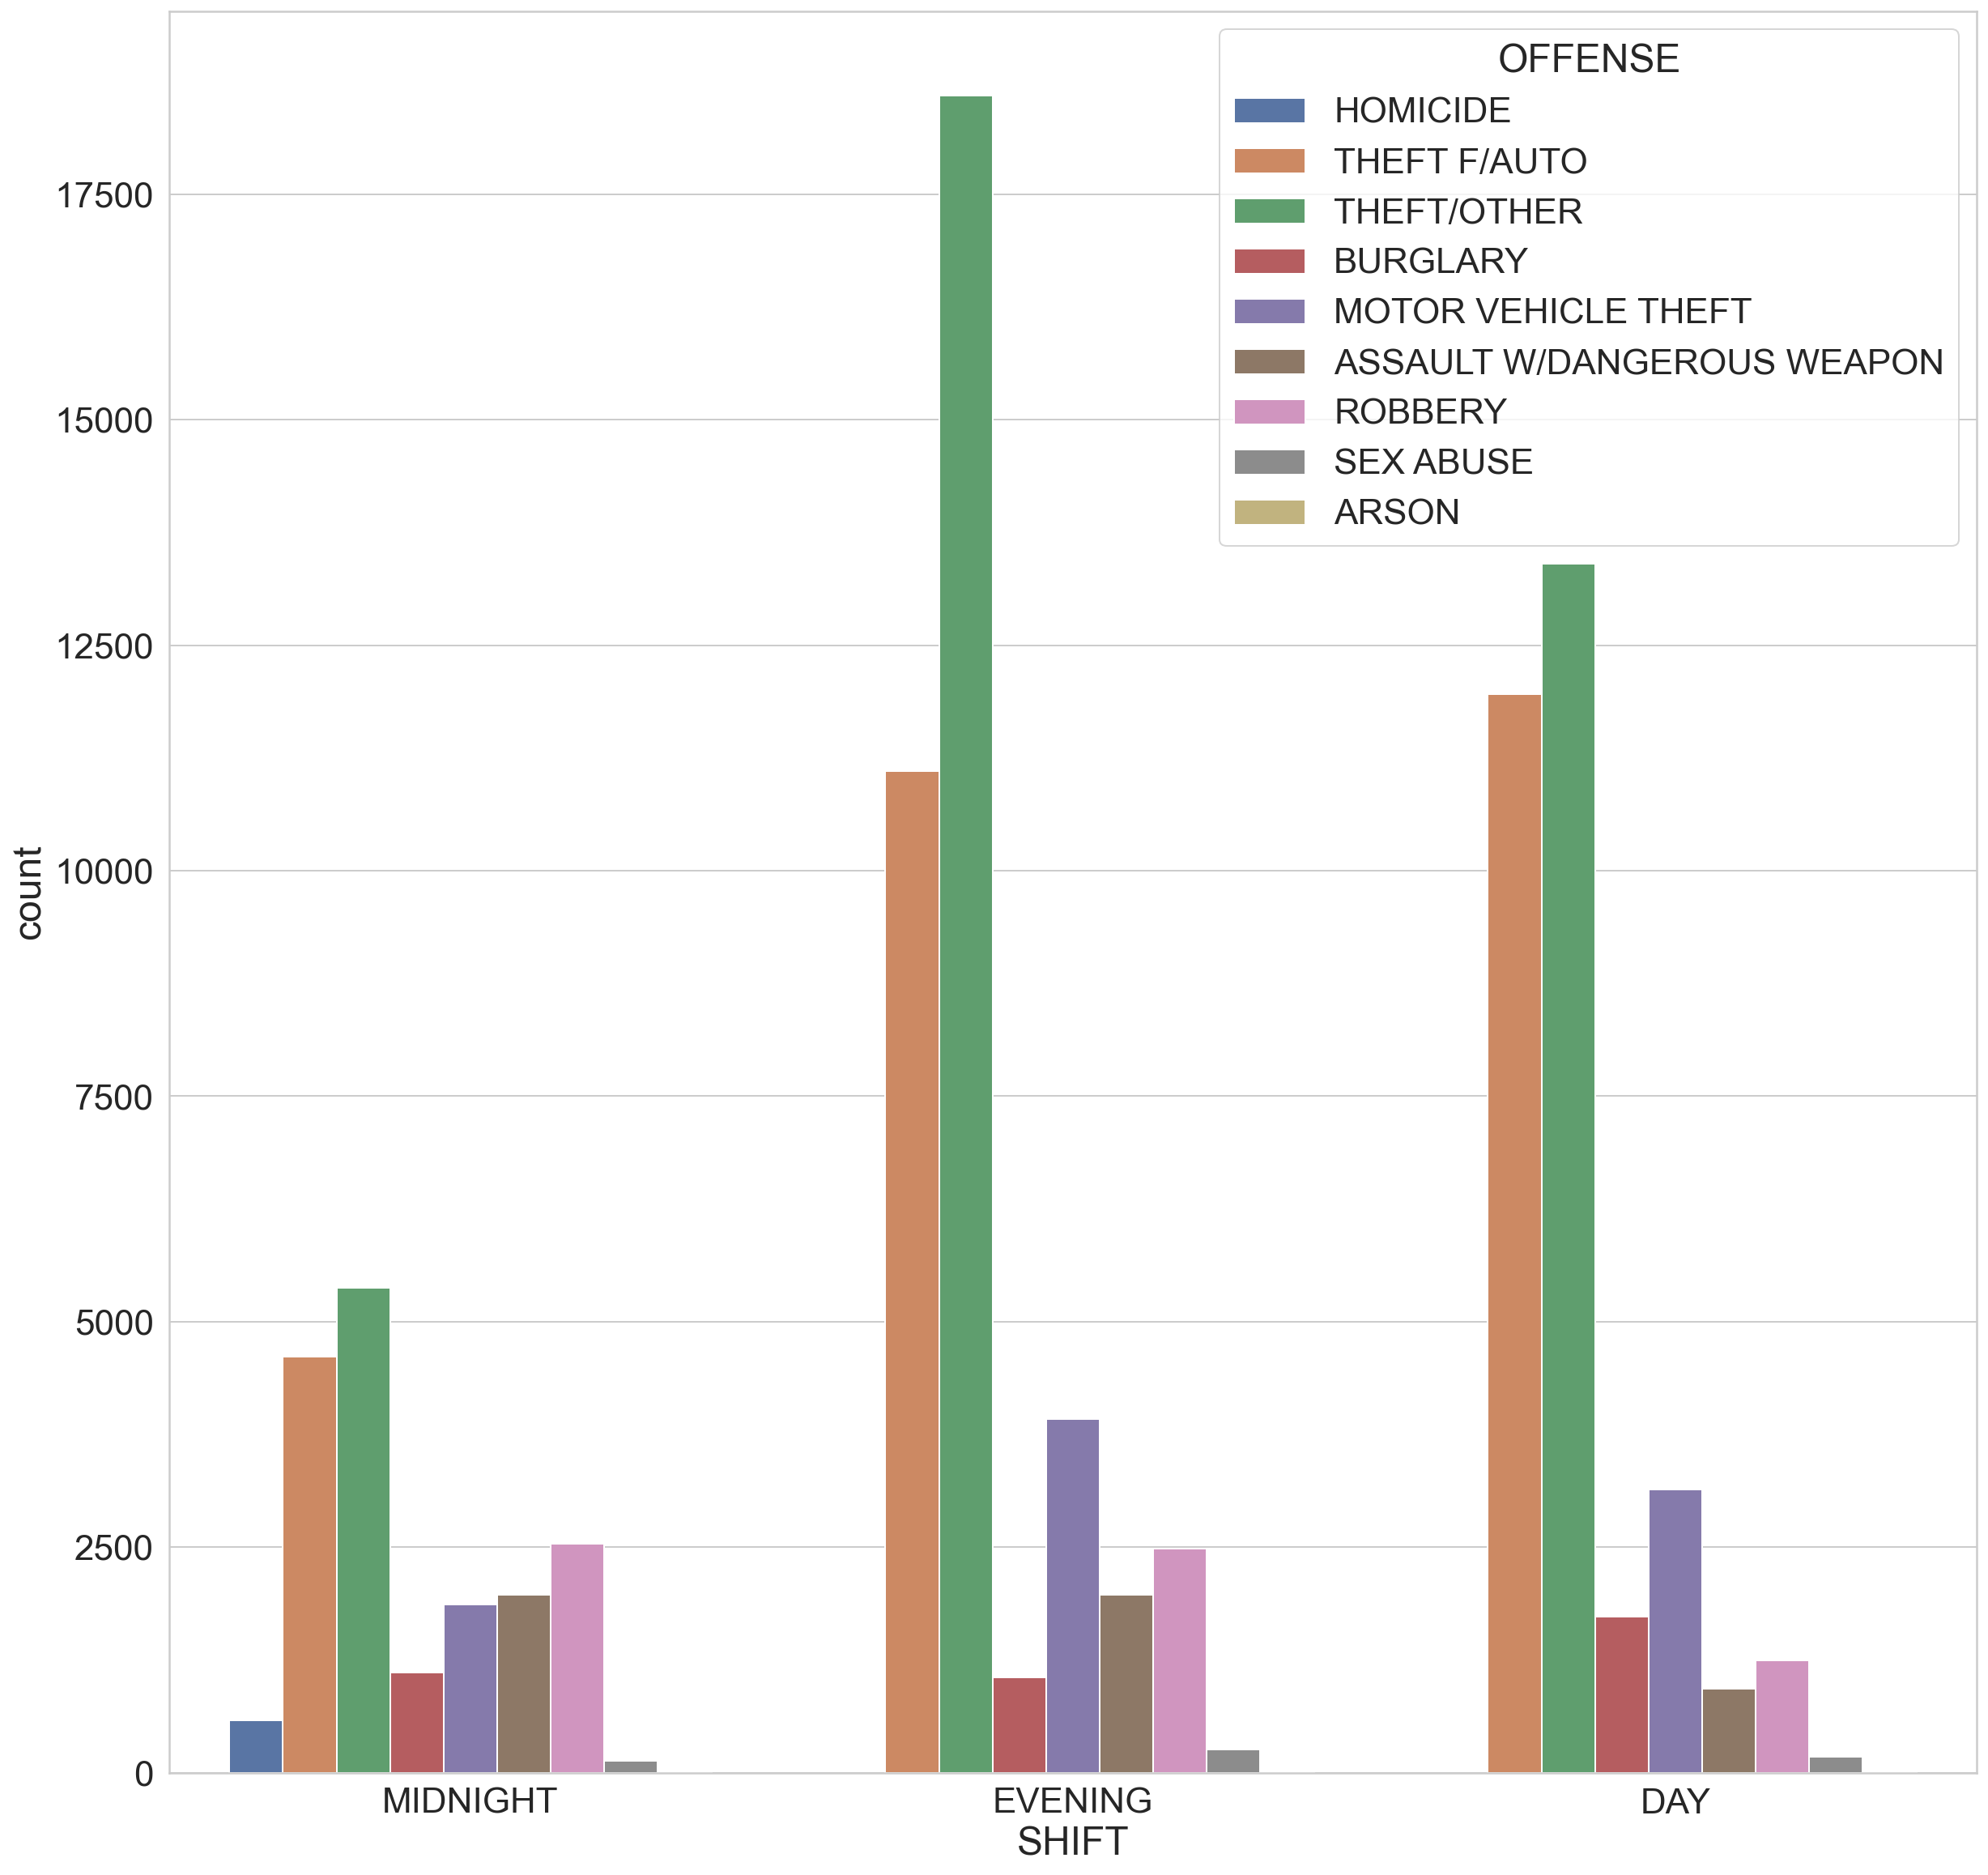

In [58]:
# print("---< offenses categorized>----")
tmp = data1[['SHIFT', 'OFFENSE']]
plt.figure(figsize=(20, 20))
sns.countplot(x='SHIFT', hue='OFFENSE', data=tmp)

<AxesSubplot:xlabel='SHIFT', ylabel='hour'>

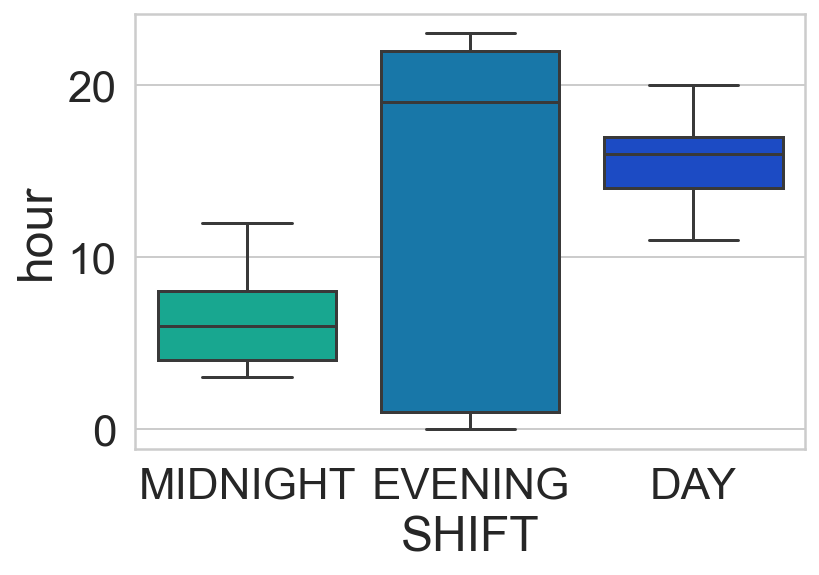

In [59]:
sns.boxplot(x='SHIFT' ,y='hour' ,data=data1 , palette='winter_r')

# Visualizing crime method used per police district(PSA)

<AxesSubplot:xlabel='DISTRICT', ylabel='count'>

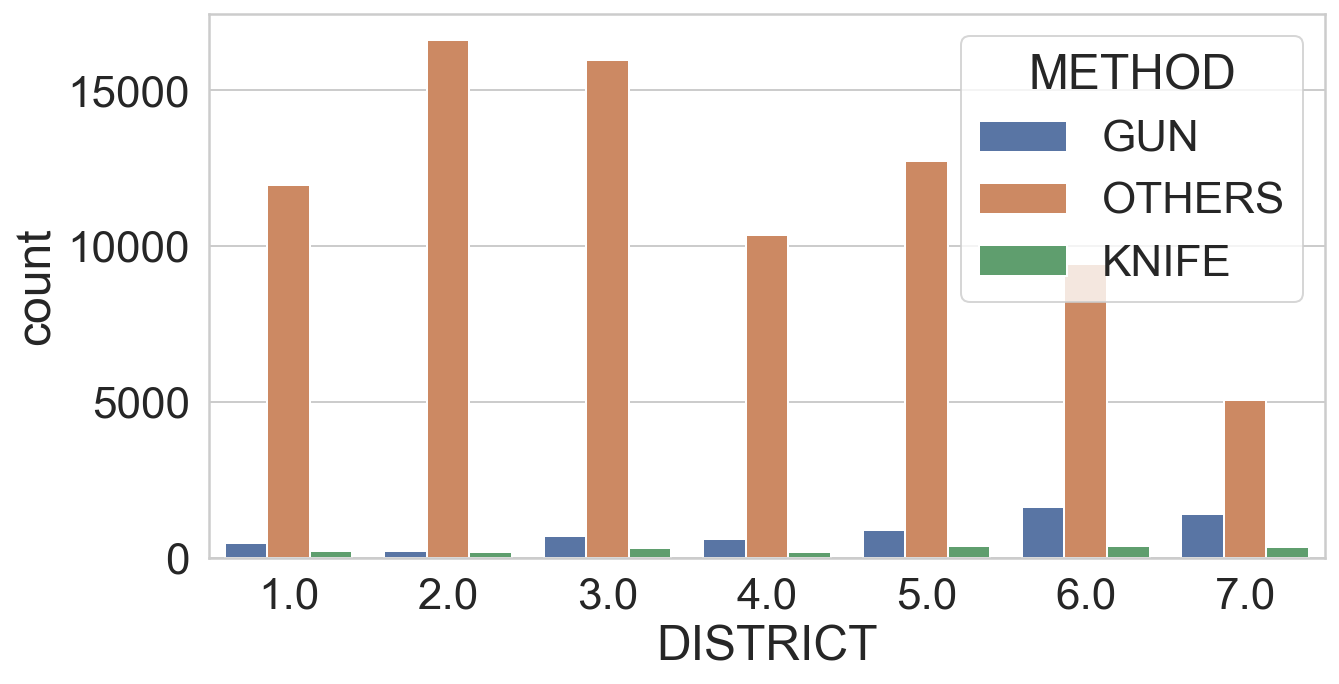

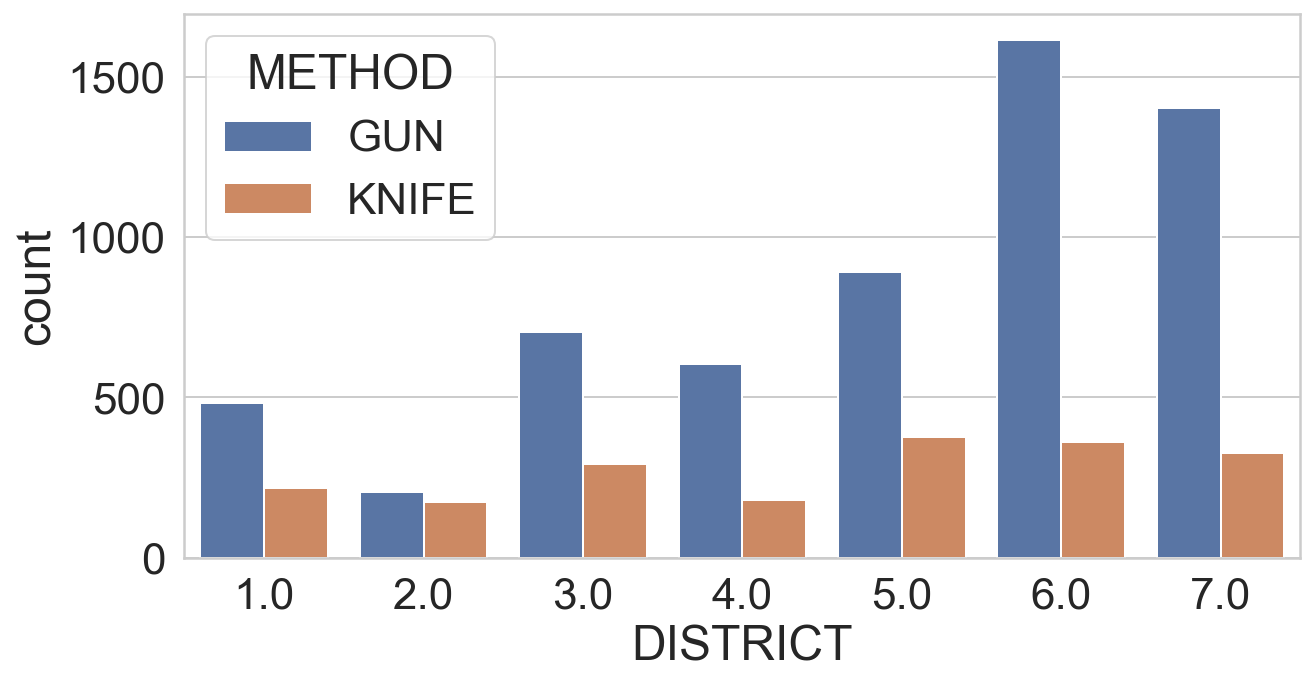

In [60]:
tmp = data1[['DISTRICT', 'METHOD']]
tmp1 = data1[['DISTRICT', 'METHOD']]
#remove Others variable
tmp1 = tmp1[tmp1['METHOD'] != "OTHERS"]

#plot bar graphs to display the total crime by method of crime and district
plt.figure(figsize=(10, 5))
sns.countplot(x='DISTRICT', hue='METHOD', data=tmp)
plt.figure(figsize=(10, 5))
sns.countplot(x='DISTRICT', hue='METHOD', data=tmp1)

#  1 = Others, 2 = Gun, 3 =  Knife

# Visualizing crimes type per police district(PSA) 

<AxesSubplot:xlabel='DISTRICT', ylabel='count'>

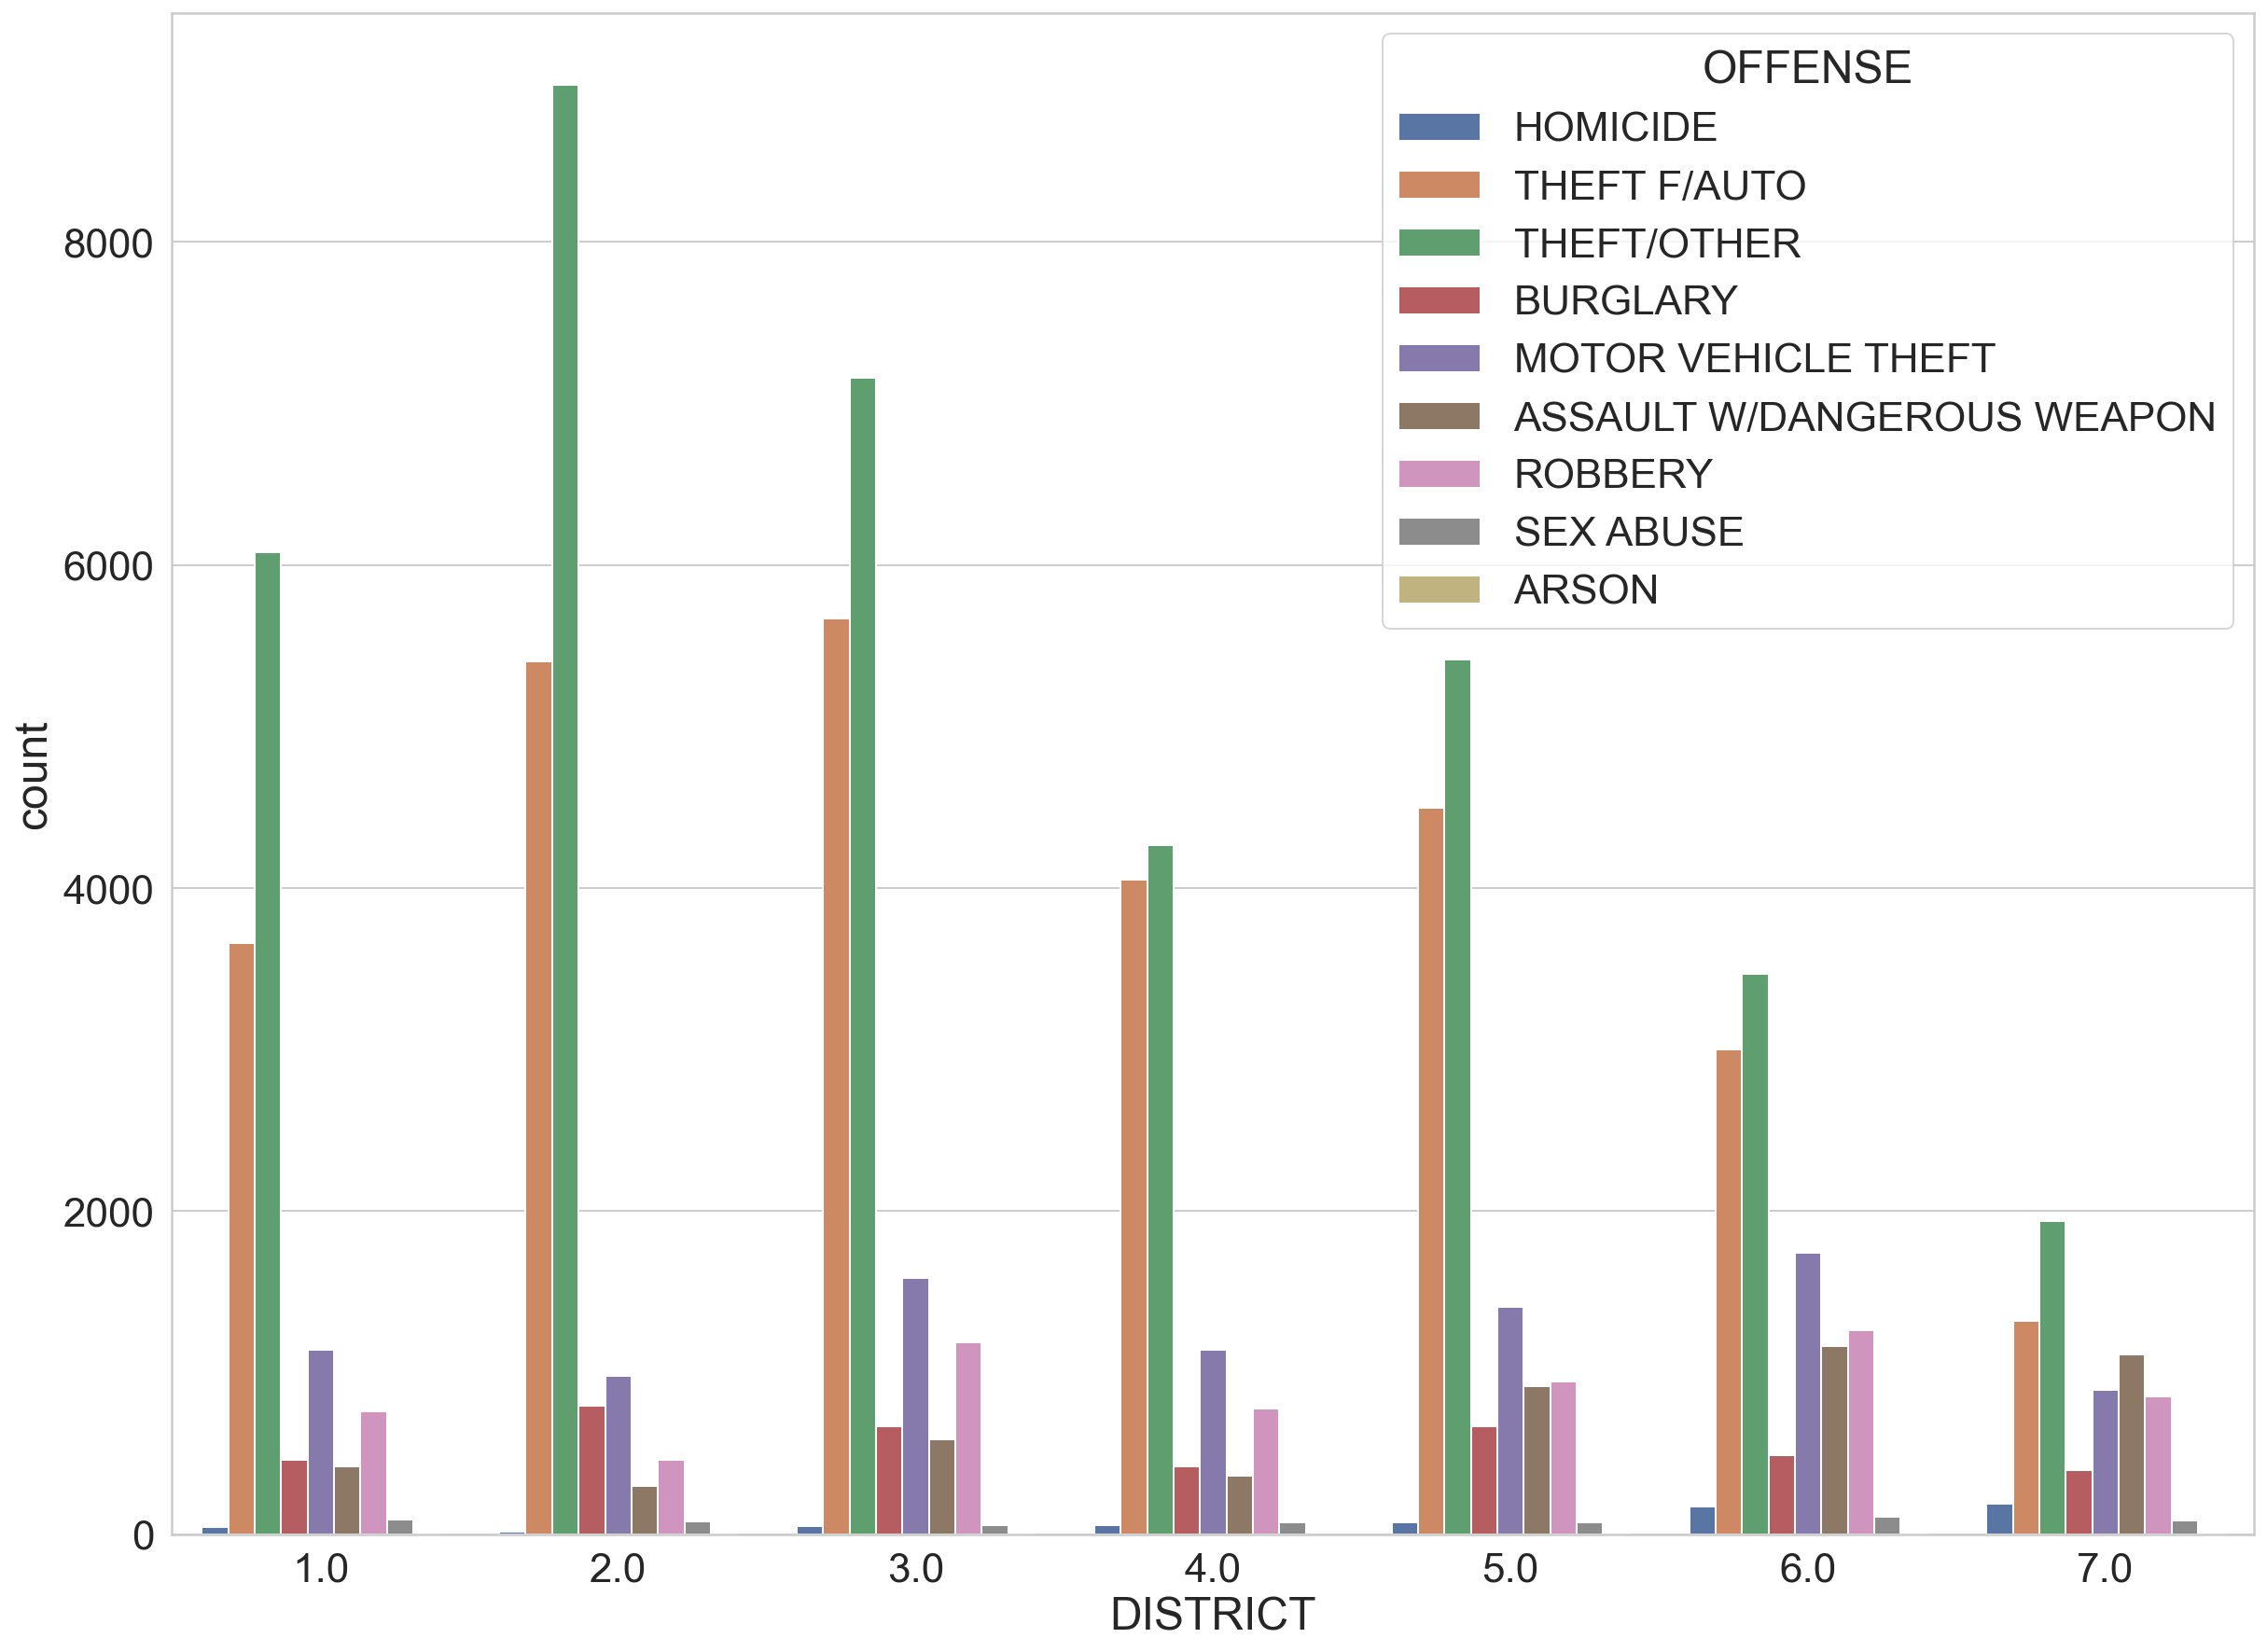

In [61]:
tmp = data1[['DISTRICT', 'OFFENSE']]
plt.figure(figsize=(20, 15))
sns.countplot(x='DISTRICT', hue='OFFENSE', data=tmp)

#  1 = Violent, 2 = nonviolent

# Visualizing Offense by Police District(PSA)

In [62]:
tmp = pd.crosstab(data1.DISTRICT, data1.OFFENSE)

tmp.plot(kind='bar', stacked=True, figsize=(25, 15))
plt.legend(loc=9, bbox_to_anchor=(.5, -.2), ncol=9)

In [63]:
data1

year  month  day  weekofyear  dayofweek  quarter  hour  minute  second  \
0      2021     12    6          49          0        4     5       0       0   
1      2021     10   13          41          2        4    21      24      42   
2      2021      8    4          31          2        3    20      36      50   
3      2021      9    1          35          2        3    12      39      59   
4      2021      8   12          32          3        3    12       0      17   
...     ...    ...  ...         ...        ...      ...   ...     ...     ...   
33923  2019      3   18          12          0        1    22       5       5   
33924  2019      3   25          13          0        1    13      51      27   
33925  2019      3   26          13          1        1    13      46      18   
33926  2019     12   29          52          6        4    16      43      42   
33927  2019     10    7          41          0        4    23       3      34   

            CCN  ...                                  BLOCK WARD ANC DISTRICT  \
0      20139232  ...   300 - 399 BLOCK OF ALLISON STREET NW    4  4C      4.0   
1      11048862  ...    3100 - 3199 BLOCK OF 35TH STREET NW    3  3C      2.0   
2      10008883  ...      300 - 348 BLOCK OF 53RD STREET SE    7  7E      6.0   
3      11124202  ...   1100 - 1199 BLOCK OF OATES STREET NE    5  5D      5.0   
4      12113231  ...  1800 - 1899 BLOCK OF CENTRAL PLACE NE    5  5D      5.0   
...         ...  ...                                    ...  ...  ..      ...   
33923  19400415  ...   806 - 899 BLOCK OF WEBSTER STREET NW    4  4C      4.0   
33924  19400417  ...     1100 - 1199 BLOCK OF 1ST STREET SE    6  6D      1.0   
33925  19400420  ...    1200 - 1299 BLOCK OF 11TH STREET NW    2  2F      3.0   
33926  19231264  ...       3248 - 3299 BLOCK OF O STREET NW    2  2E      2.0   
33927  19401414  ...  1400 - 1499 BLOCK OF GIRARD STREET NW    1  1A      3.0   

         PSA NEIGHBORHOOD_CLUSTER  CENSUS_TRACT  VOTING_PRECINCT   LATITUDE  \
0      407.0           Cluster 18        2301.0      Precinct 46  38.945349   
1      204.0           Cluster 15         600.0      Precinct 27  38.932075   
2      604.0           Cluster 33        9905.0     Precinct 105  38.884369   
3      506.0           Cluster 23        8802.0      Precinct 77  38.905924   
4      506.0           Cluster 23        8803.0      Precinct 76  38.912520   
...      ...                  ...           ...              ...        ...   
33923  407.0           Cluster 18        2400.0      Precinct 46  38.944030   
33924  106.0           Cluster 27        7202.0     Precinct 131  38.877005   
33925  307.0            Cluster 7        5004.0      Precinct 17  38.906444   
33926  206.0            Cluster 4         202.0       Precinct 6  38.907801   
33927  304.0            Cluster 2        3702.0      Precinct 36  38.925403   

       LONGITUDE  
0     -77.016425  
1     -77.068635  
2     -76.926218  
3     -76.989341  
4     -76.985590  
...          ...  
33923 -77.024747  
33924 -77.005874  
33925 -77.027037  
33926 -77.065674  
33927 -77.033870  

[90161 rows x 23 columns]

Visualization by crime type per month

<AxesSubplot:xlabel='month', ylabel='count'>

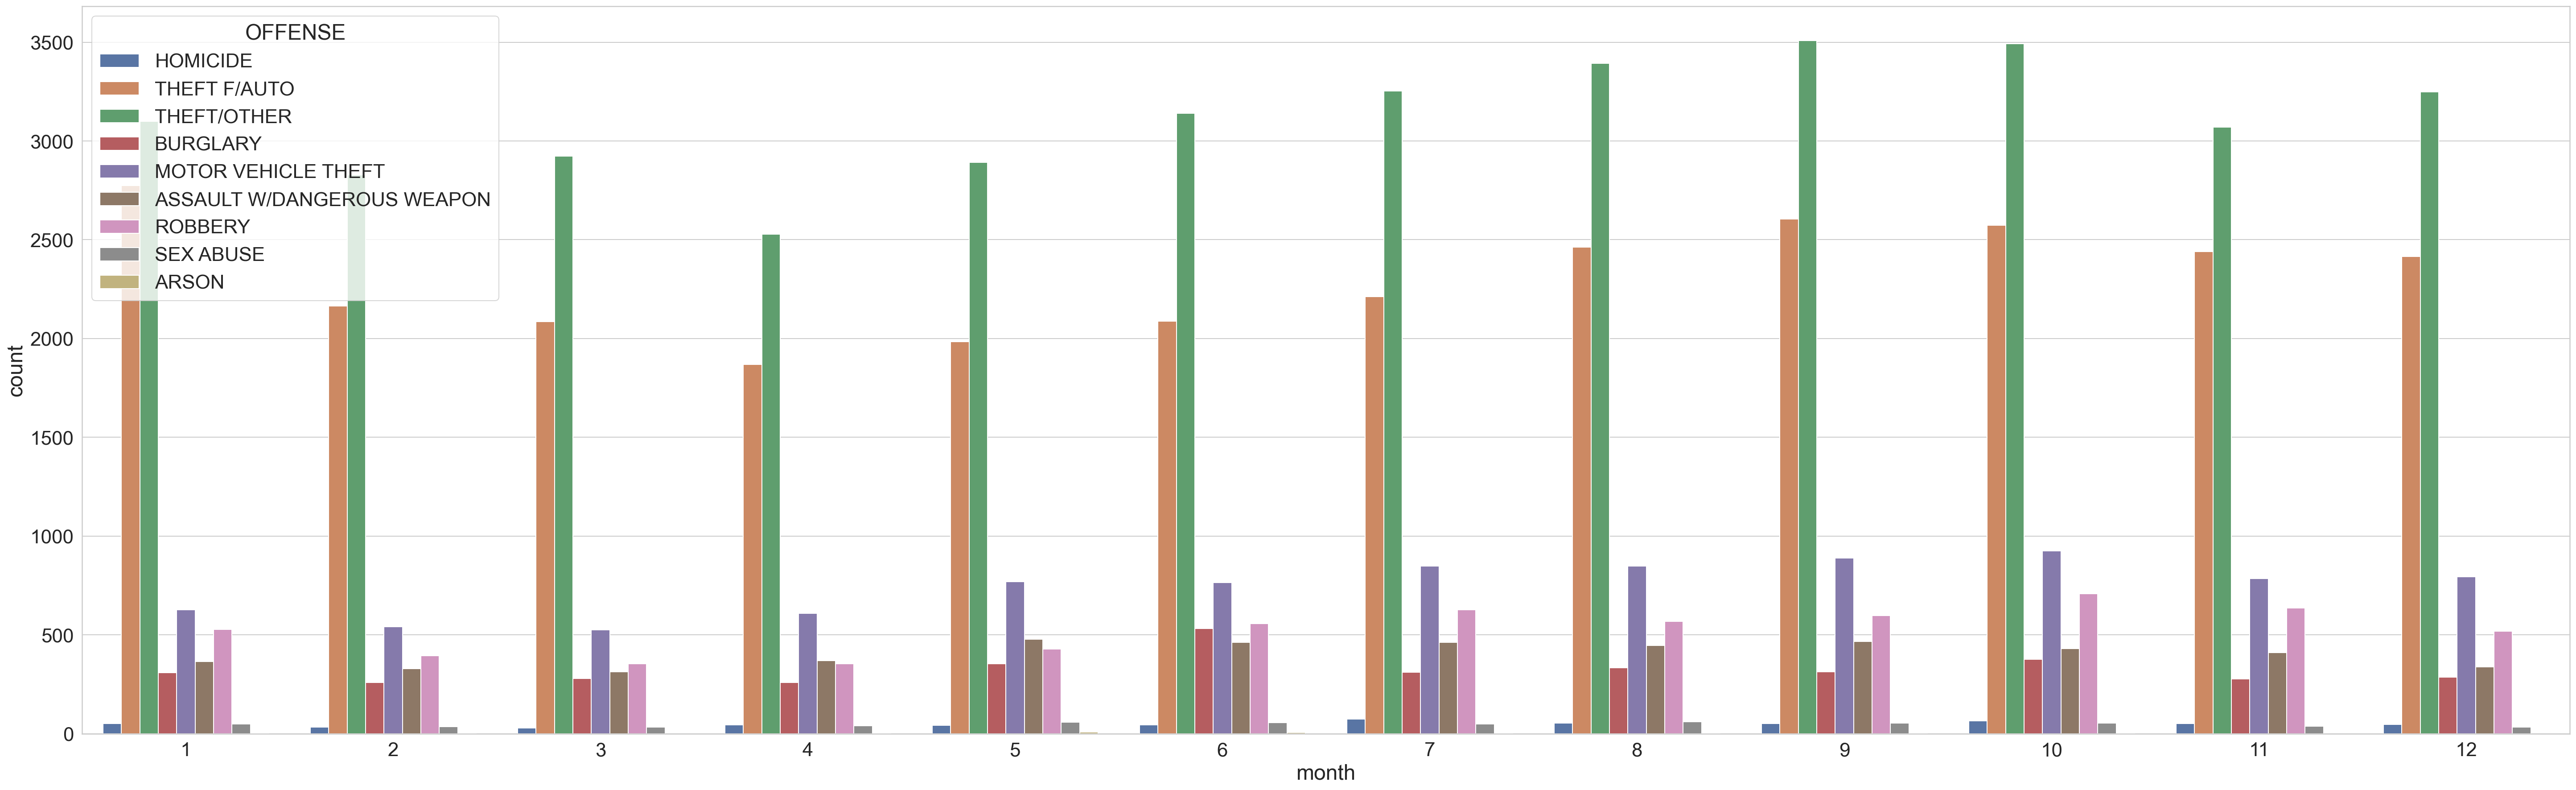

In [64]:
tmp = data1[['month', 'OFFENSE']]
plt.figure(figsize=(50, 15))
sns.countplot(x='month', hue='OFFENSE', data=tmp)

<AxesSubplot:xlabel='weekofyear', ylabel='count'>

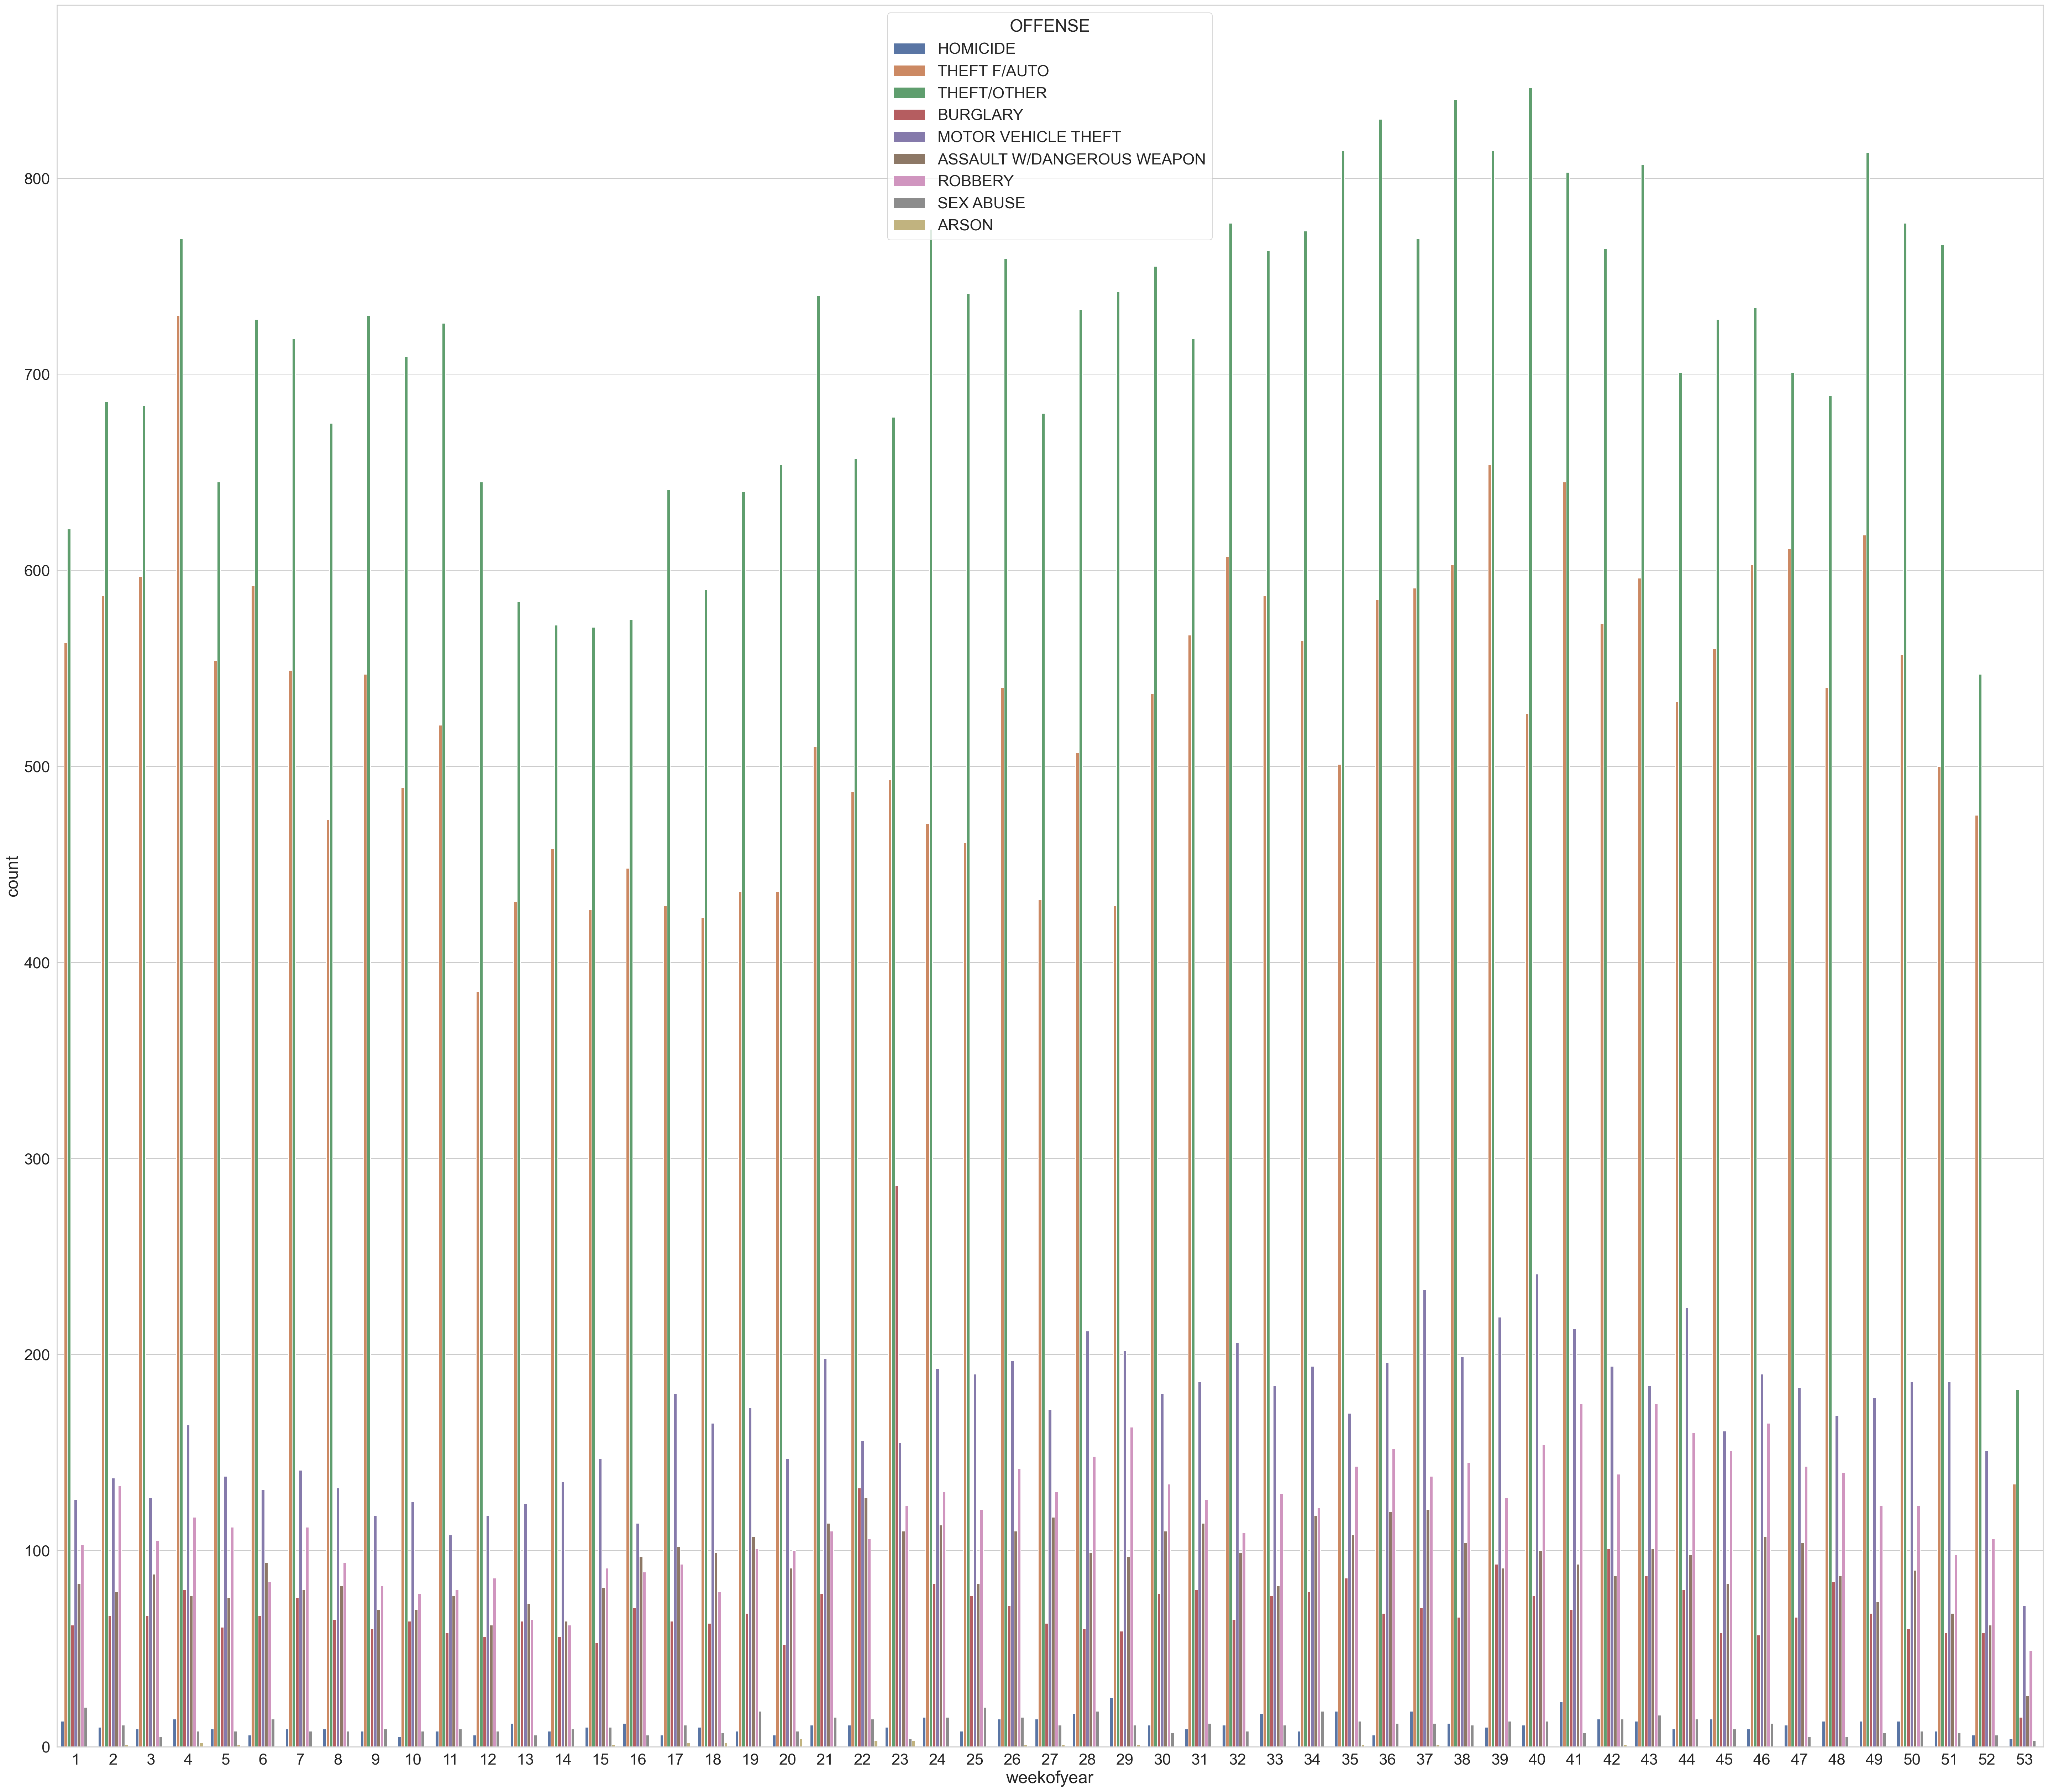

In [66]:
tmp = data1[['weekofyear', 'OFFENSE']]
plt.figure(figsize=(50, 45))
sns.countplot(x= 'weekofyear', hue='OFFENSE', data=tmp)

In [67]:
data1.columns

Index(['year', 'month', 'day', 'weekofyear', 'dayofweek', 'quarter', 'hour',
       'minute', 'second', 'CCN', 'SHIFT', 'METHOD', 'OFFENSE', 'BLOCK',
       'WARD', 'ANC', 'DISTRICT', 'PSA', 'NEIGHBORHOOD_CLUSTER',
       'CENSUS_TRACT', 'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

<AxesSubplot:xlabel='quarter', ylabel='count'>

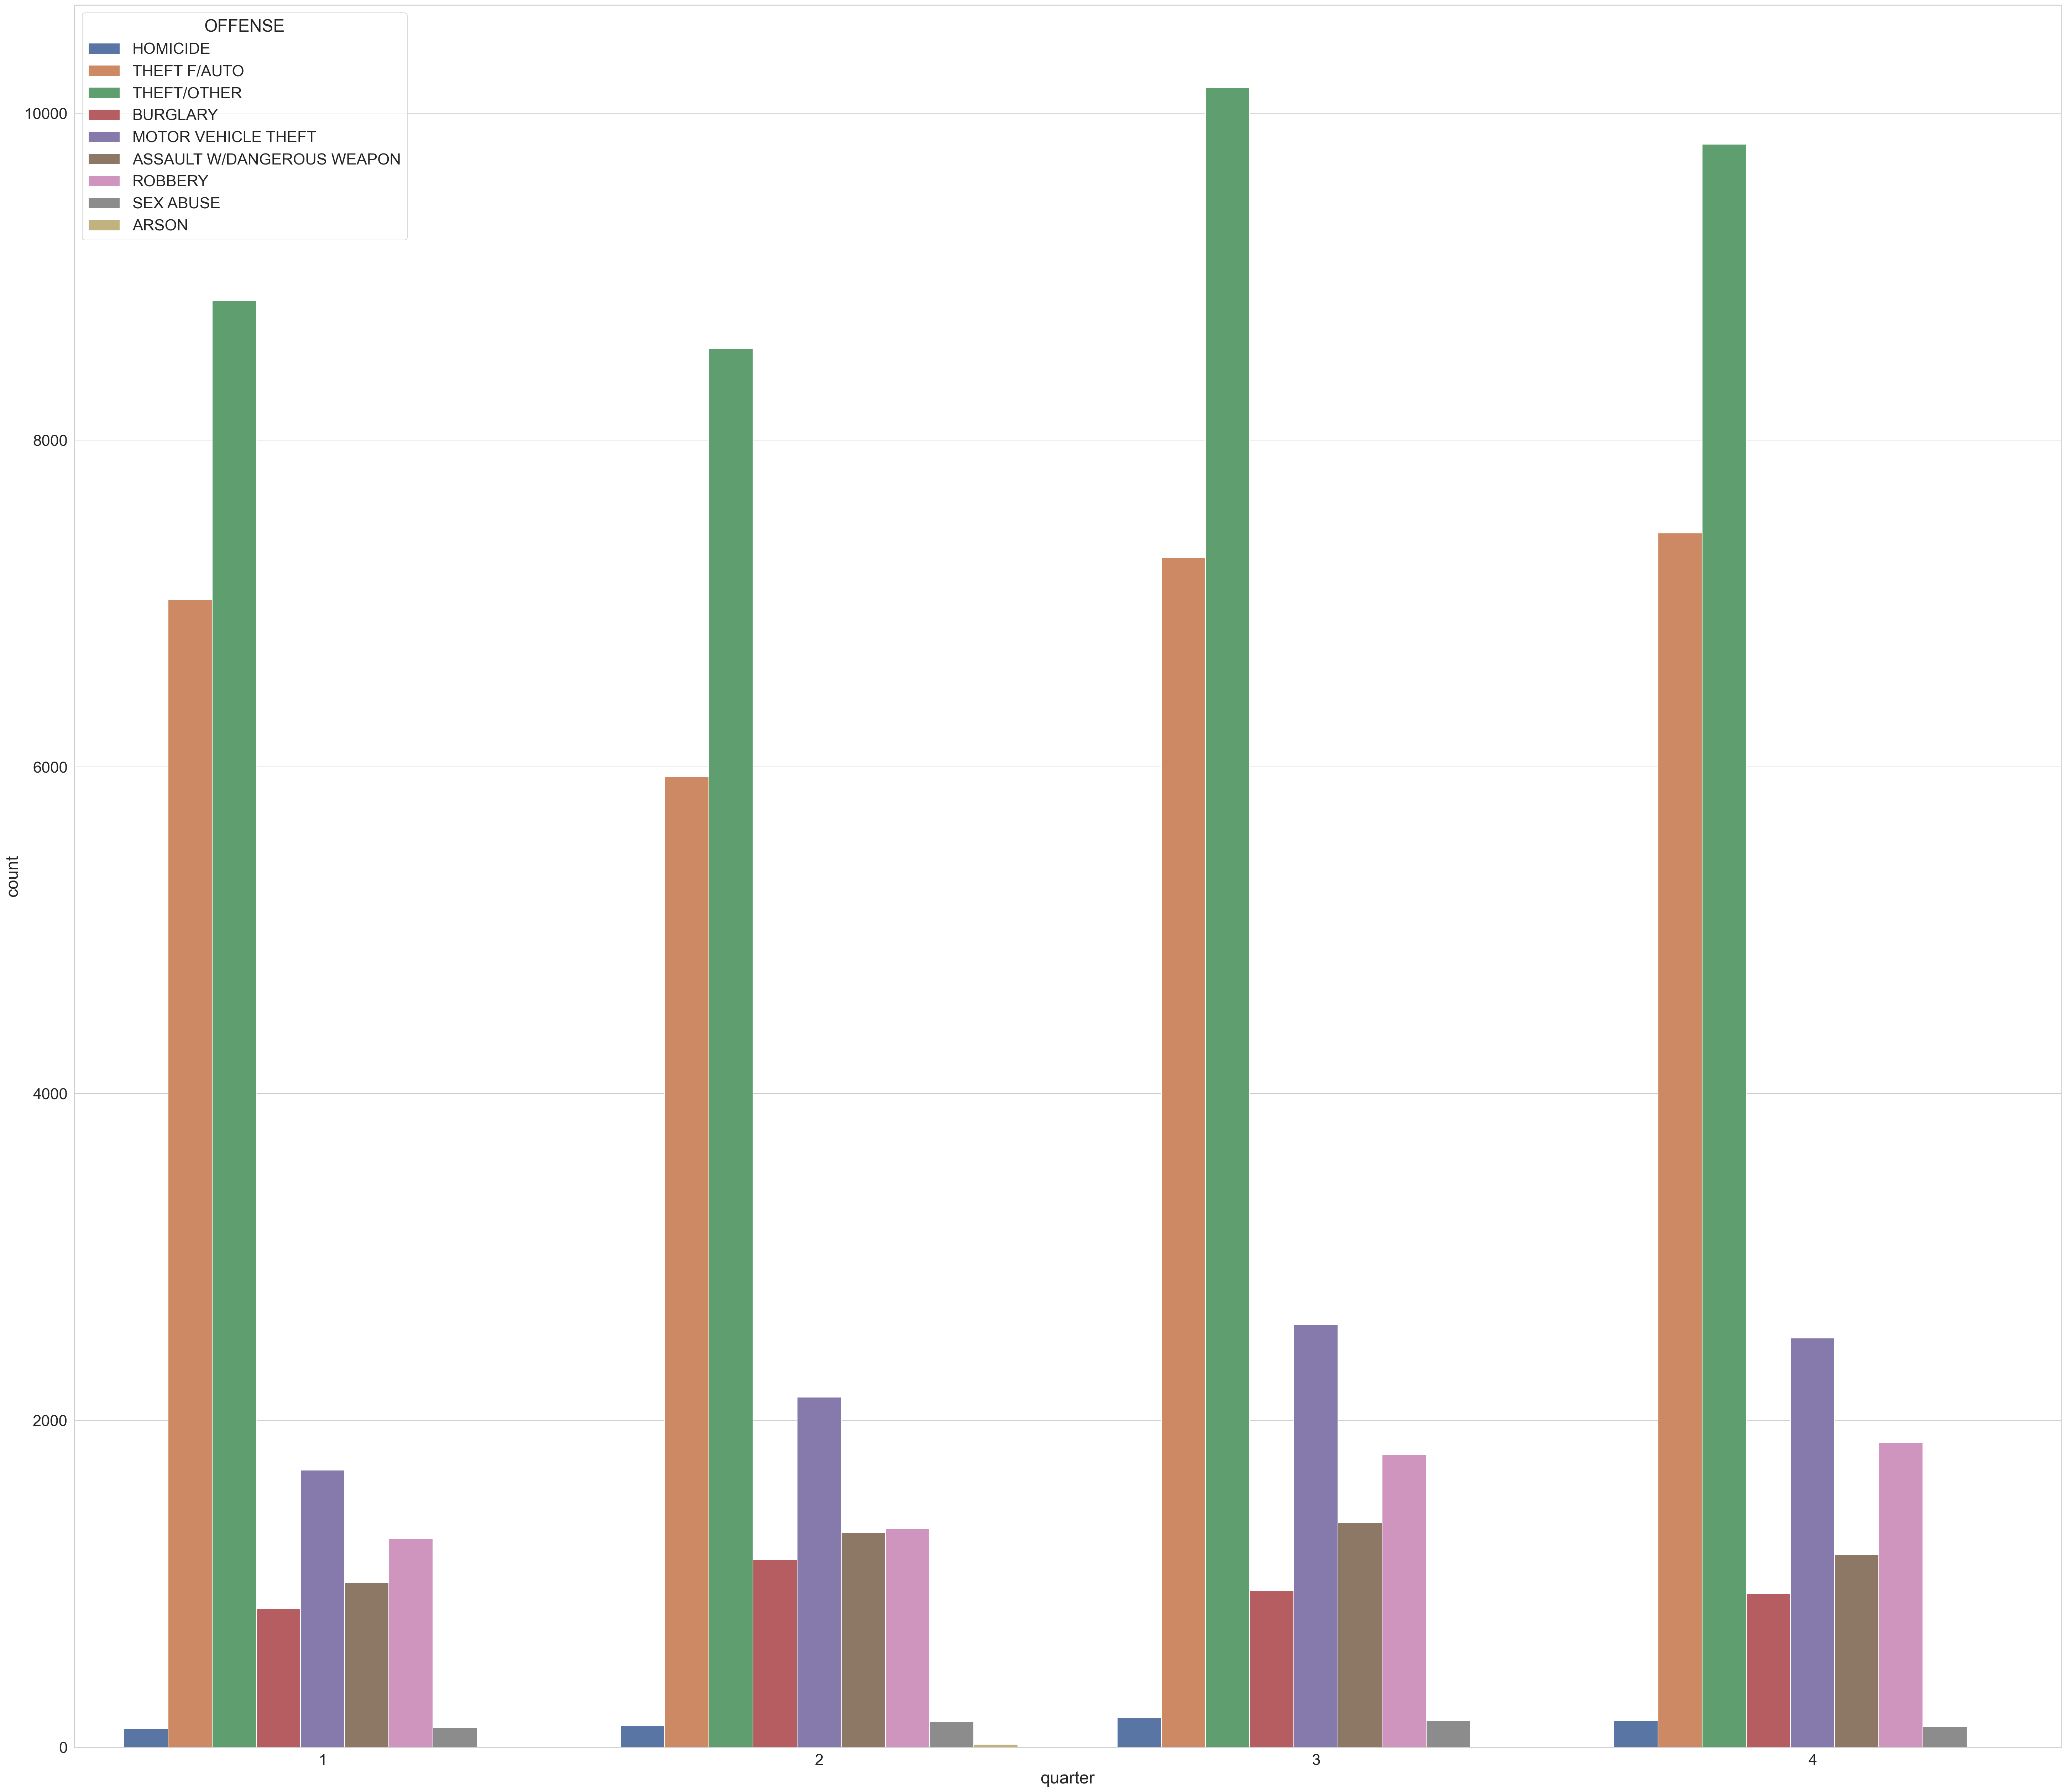

In [68]:
tmp = data1[['quarter', 'OFFENSE']]
plt.figure(figsize=(50, 45))
sns.countplot(x= 'quarter', hue='OFFENSE', data=tmp)

# Relationships between Attributes

Offense by Police Shift

In [69]:
def percentConv(x):
    return x / float(sum(x))

print( pd.crosstab(data1.OFFENSE, data1.SHIFT).apply(percentConv, axis=1))

SHIFT                            DAY   EVENING  MIDNIGHT
OFFENSE                                                 
ARSON                       0.360000  0.480000  0.160000
ASSAULT W/DANGEROUS WEAPON  0.190183  0.405217  0.404601
BURGLARY                    0.444159  0.271230  0.284611
HOMICIDE                    0.000000  0.000000  1.000000
MOTOR VEHICLE THEFT         0.351972  0.439601  0.208427
ROBBERY                     0.198244  0.396488  0.405267
SEX ABUSE                   0.312388  0.454219  0.233393
THEFT F/AUTO                0.432082  0.401221  0.166697
THEFT/OTHER                 0.358633  0.497512  0.143855


Crime Type by Police District

In [70]:
print (pd.crosstab(data1.DISTRICT, data1.OFFENSE, margins=True))
print ('-----------------------------------------------------')
print (pd.crosstab(data1.DISTRICT, data1.OFFENSE).apply(percentConv, axis=1))

print('---------------------------------------------------------------') 
print ('Percentage of Crime in each District')
print("======================================")
tmp_total = data1.DISTRICT.value_counts().sum()
print(data1.DISTRICT.value_counts() / tmp_total)

OFFENSE   ARSON  ASSAULT W/DANGEROUS WEAPON  BURGLARY  HOMICIDE  \
DISTRICT                                                          
1.0           3                         422       458        45   
2.0           6                         296       792        14   
3.0           2                         585       670        47   
4.0           0                         364       417        53   
5.0           5                         914       665        70   
6.0           5                        1164       486       169   
7.0           4                        1114       394       186   
All          25                        4859      3882       584   

OFFENSE   MOTOR VEHICLE THEFT  ROBBERY  SEX ABUSE  THEFT F/AUTO  THEFT/OTHER  \
DISTRICT                                                                       
1.0                      1140      761         90          3657         6077   
2.0                       980      462         76          5400         8969   
3.0      

Based on the above crosstabulation of Offense by Police District(PSA) and percentage of crime in each district shows that district 7 is the safest by a factor of 1.8 compared to the unsafest district 1(0.18).

Offense by Method

In [73]:
print("===============================================")
print (pd.crosstab(data1.OFFENSE, data1.METHOD, margins=True))
print("================================================")

METHOD                       GUN  KNIFE  OTHERS    All
OFFENSE                                               
ARSON                          0      0      25     25
ASSAULT W/DANGEROUS WEAPON  2489   1404     976   4869
BURGLARY                      30      6    3850   3886
HOMICIDE                     483     30      71    584
MOTOR VEHICLE THEFT           10      4    8910   8924
ROBBERY                     2854    394    3017   6265
SEX ABUSE                     22     27     508    557
THEFT F/AUTO                  17      3   27653  27673
THEFT/OTHER                   20     59   37299  37378
All                         5925   1927   82309  90161


In [74]:
print("==========================================================")
print(pd.crosstab(data1.OFFENSE, data1.METHOD).apply(percentConv, axis=1))
print("==========================================================")

METHOD                           GUN     KNIFE    OTHERS
OFFENSE                                                 
ARSON                       0.000000  0.000000  1.000000
ASSAULT W/DANGEROUS WEAPON  0.511193  0.288355  0.200452
BURGLARY                    0.007720  0.001544  0.990736
HOMICIDE                    0.827055  0.051370  0.121575
MOTOR VEHICLE THEFT         0.001121  0.000448  0.998431
ROBBERY                     0.455547  0.062889  0.481564
SEX ABUSE                   0.039497  0.048474  0.912029
THEFT F/AUTO                0.000614  0.000108  0.999277
THEFT/OTHER                 0.000535  0.001578  0.997886


Crime by Days of the week

In [75]:
print("==============================================================================================================")
# 0 = Monday, 6 = Sunday

# set index to the start of the crime
g = data1.dayofweek
print( pd.crosstab(data1.OFFENSE, g, colnames=['dayofweek'], margins=True))
print("==============================================================================================================")
print(pd.crosstab(data1.OFFENSE, g, colnames=['dayofweek']).apply(percentConv, axis=1))
print("============================================================================================================")
#          

dayofweek                       0      1      2      3      4      5      6  \
OFFENSE                                                                       
ARSON                           1      5      6      3      5      2      3   
ASSAULT W/DANGEROUS WEAPON    659    702    670    591    633    794    820   
BURGLARY                      758    614    561    546    525    435    447   
HOMICIDE                       76     72     68     82     92     95     99   
MOTOR VEHICLE THEFT          1384   1329   1313   1201   1240   1239   1218   
ROBBERY                       868    869    869    836    855    978    990   
SEX ABUSE                      65     75     72     80    104     77     84   
THEFT F/AUTO                 4177   4095   4093   3875   3769   3856   3808   
THEFT/OTHER                  5413   5928   5829   5456   5173   4926   4653   
All                         13401  13689  13481  12670  12396  12402  12122   

dayofweek                     All  
OFFENSE        

Violent Crime by Location

========================== Plot of violent crimes==========================================================


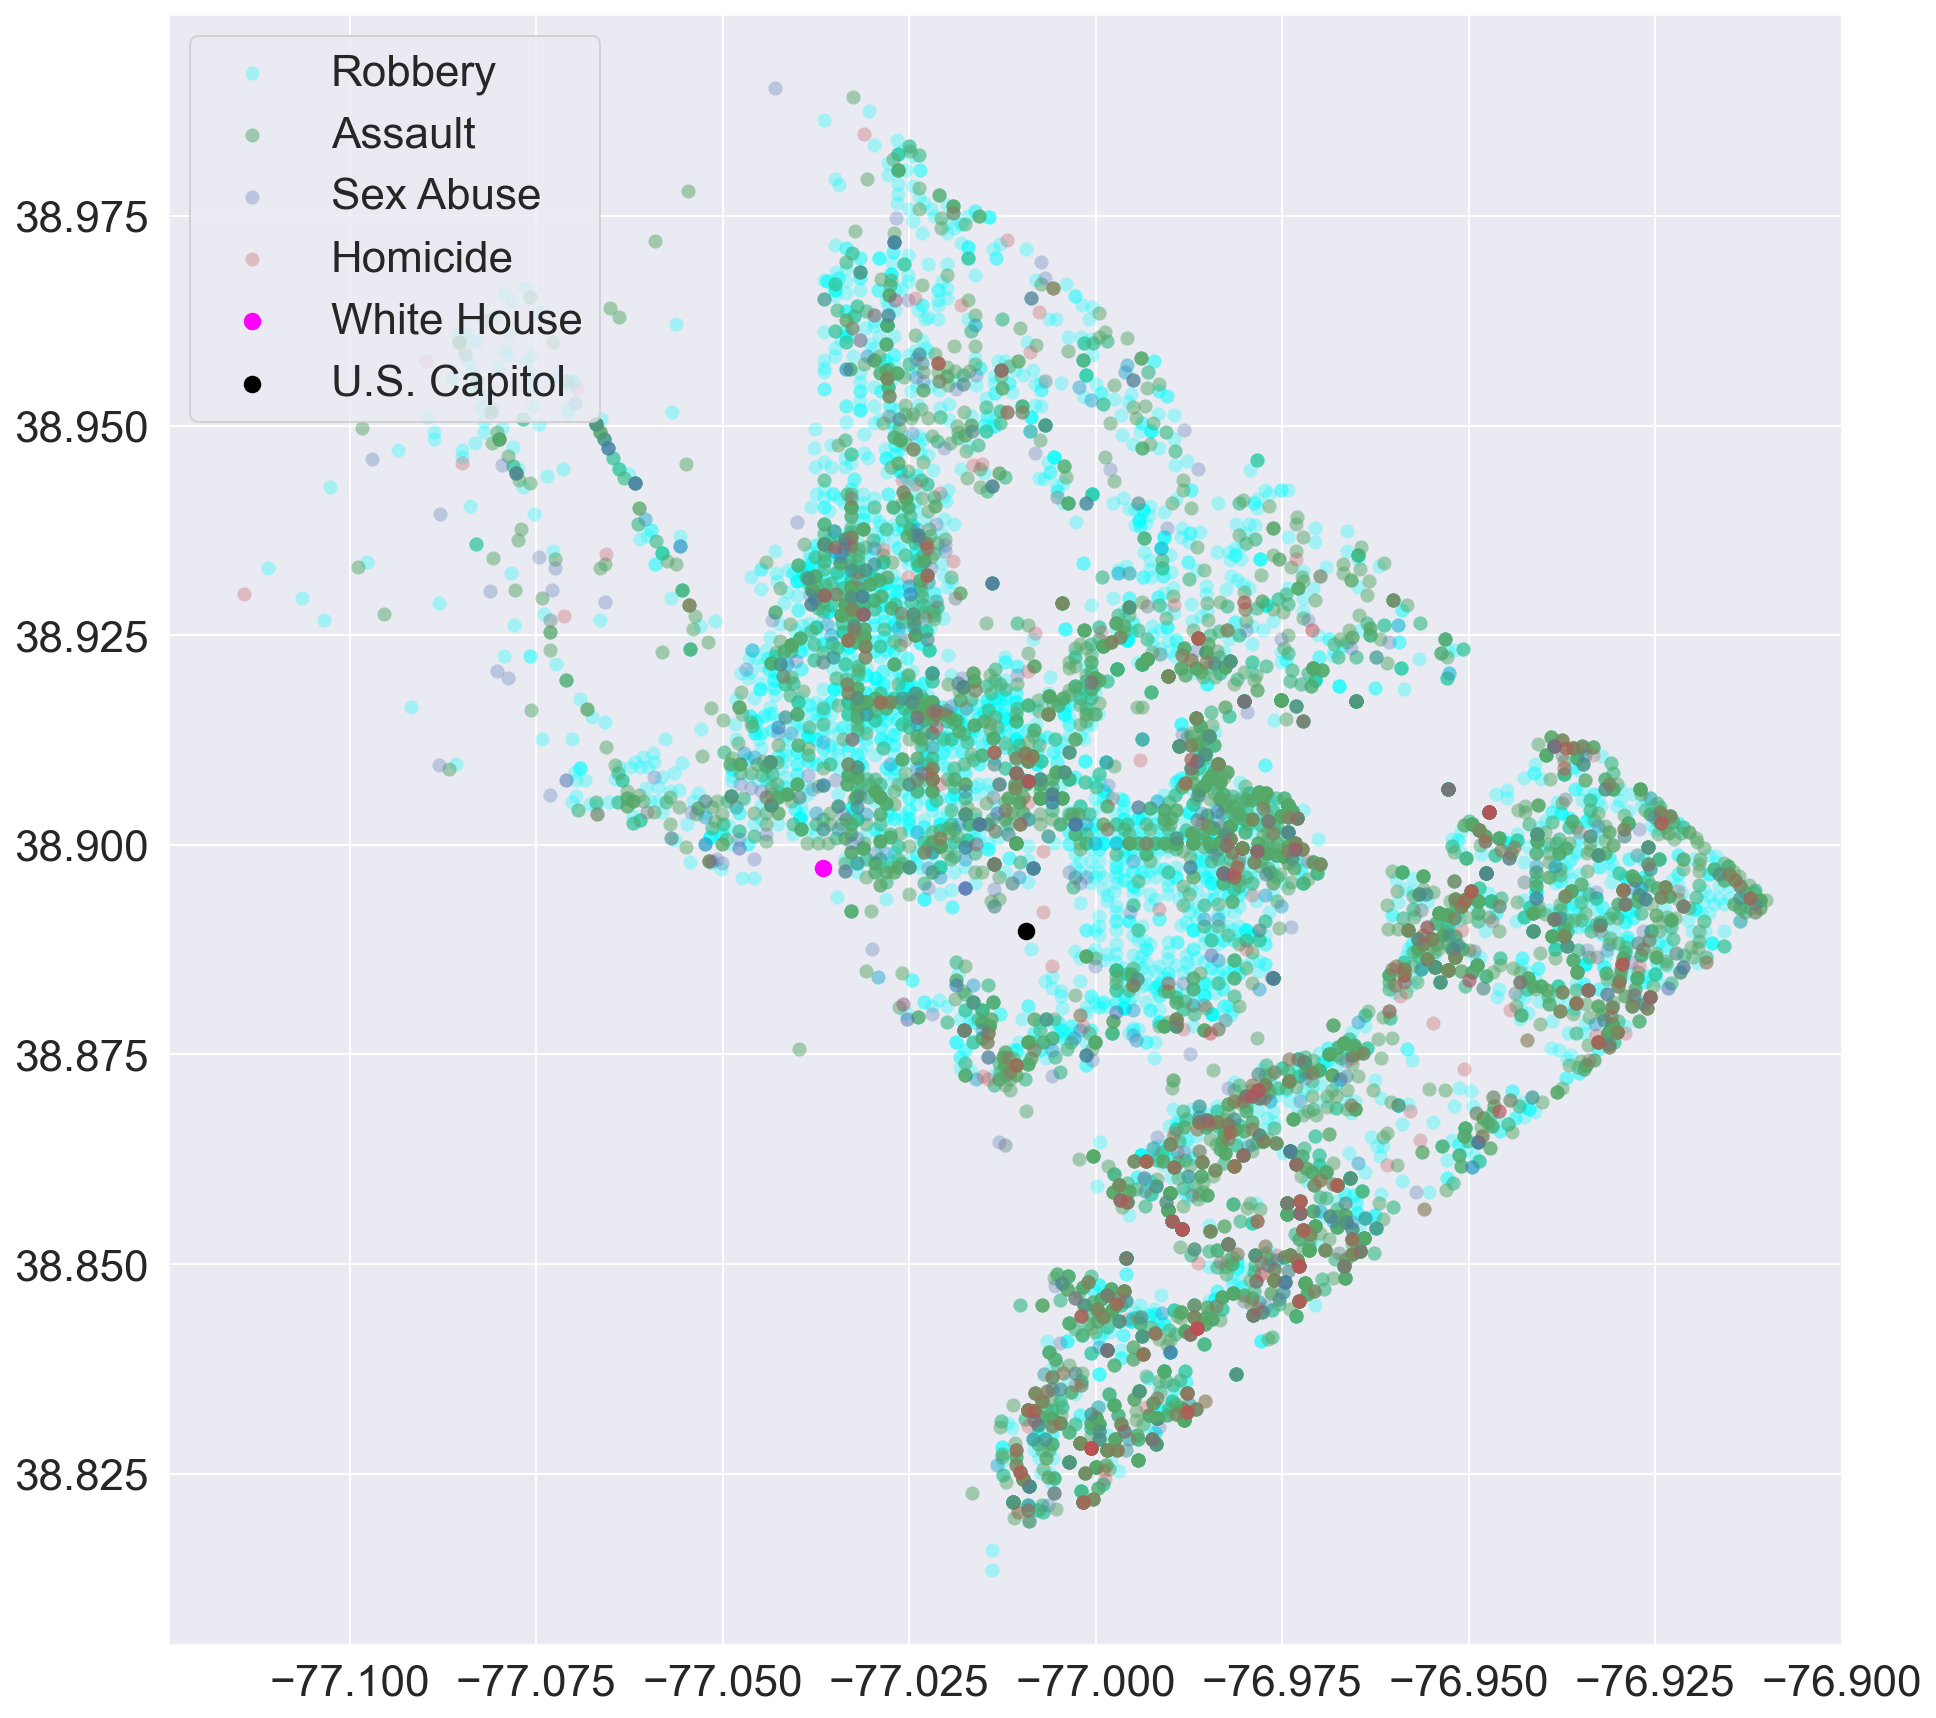

========================== Plot of violent crimes===========================================================


In [80]:
print("========================== Plot of violent crimes==========================================================")
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ROBBERY'], data1['LATITUDE'][data1['OFFENSE']=='ROBBERY'], s=50, alpha=0.3, color=[0.0,1.0,1.0], lw=0, label='Robbery')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], data1['LATITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], s=50, alpha=0.5, color='g', lw=0, label='Assault')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='SEX ABUSE'], data1['LATITUDE'][data1['OFFENSE']=='SEX ABUSE'], s=50, alpha=0.3, color='b', lw=0, label='Sex Abuse')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='HOMICIDE'], data1['LATITUDE'][data1['OFFENSE']=='HOMICIDE'], s=50, alpha=0.3, color='r', lw=0, label='Homicide')
plt.scatter(-77.03654,38.89722,s=60, color=[1,0,1], lw=1, label='White House')
plt.scatter(-77.00937,38.88968,s=60, color=[0,0,0], lw=1, label='U.S. Capitol')
plt.legend(loc='upper left')
plt.show()
print("========================== Plot of violent crimes===========================================================")

In [143]:
print("========================== Plot of violent crimes=============================================================")
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ROBBERY'], data1['LATITUDE'][data1['OFFENSE']=='ROBBERY'], s=50, alpha=0.3, color=[0.0,1.0,1.0], lw=0, label='Robbery')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], data1['LATITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], s=50, alpha=0.5, color='g', lw=0, label='Assault')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='SEX ABUSE'], data1['LATITUDE'][data1['OFFENSE']=='SEX ABUSE'], s=50, alpha=0.3, color='b', lw=0, label='Sex Abuse')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='HOMICIDE'], data1['LATITUDE'][data1['OFFENSE']=='HOMICIDE'], s=50, alpha=0.3, color='r', lw=0, label='Homicide')
plt.scatter(-77.03654,38.89722,s=60, color=[1,0,1], lw=10, label='White House')
plt.scatter(-77.00937,38.88968,s=60, color=[0,0,0], lw=10, label='U.S. Capitol')
plt.legend(loc='upper right')
plt.show()
print("========================== violent crimes in Washington DC ====================================================")

========================== Plot of violent crimes=============================================================


========================== violent crimes in Washington DC ====================================================


========================== Plot of violent[ROBBERY]crimes====================================================


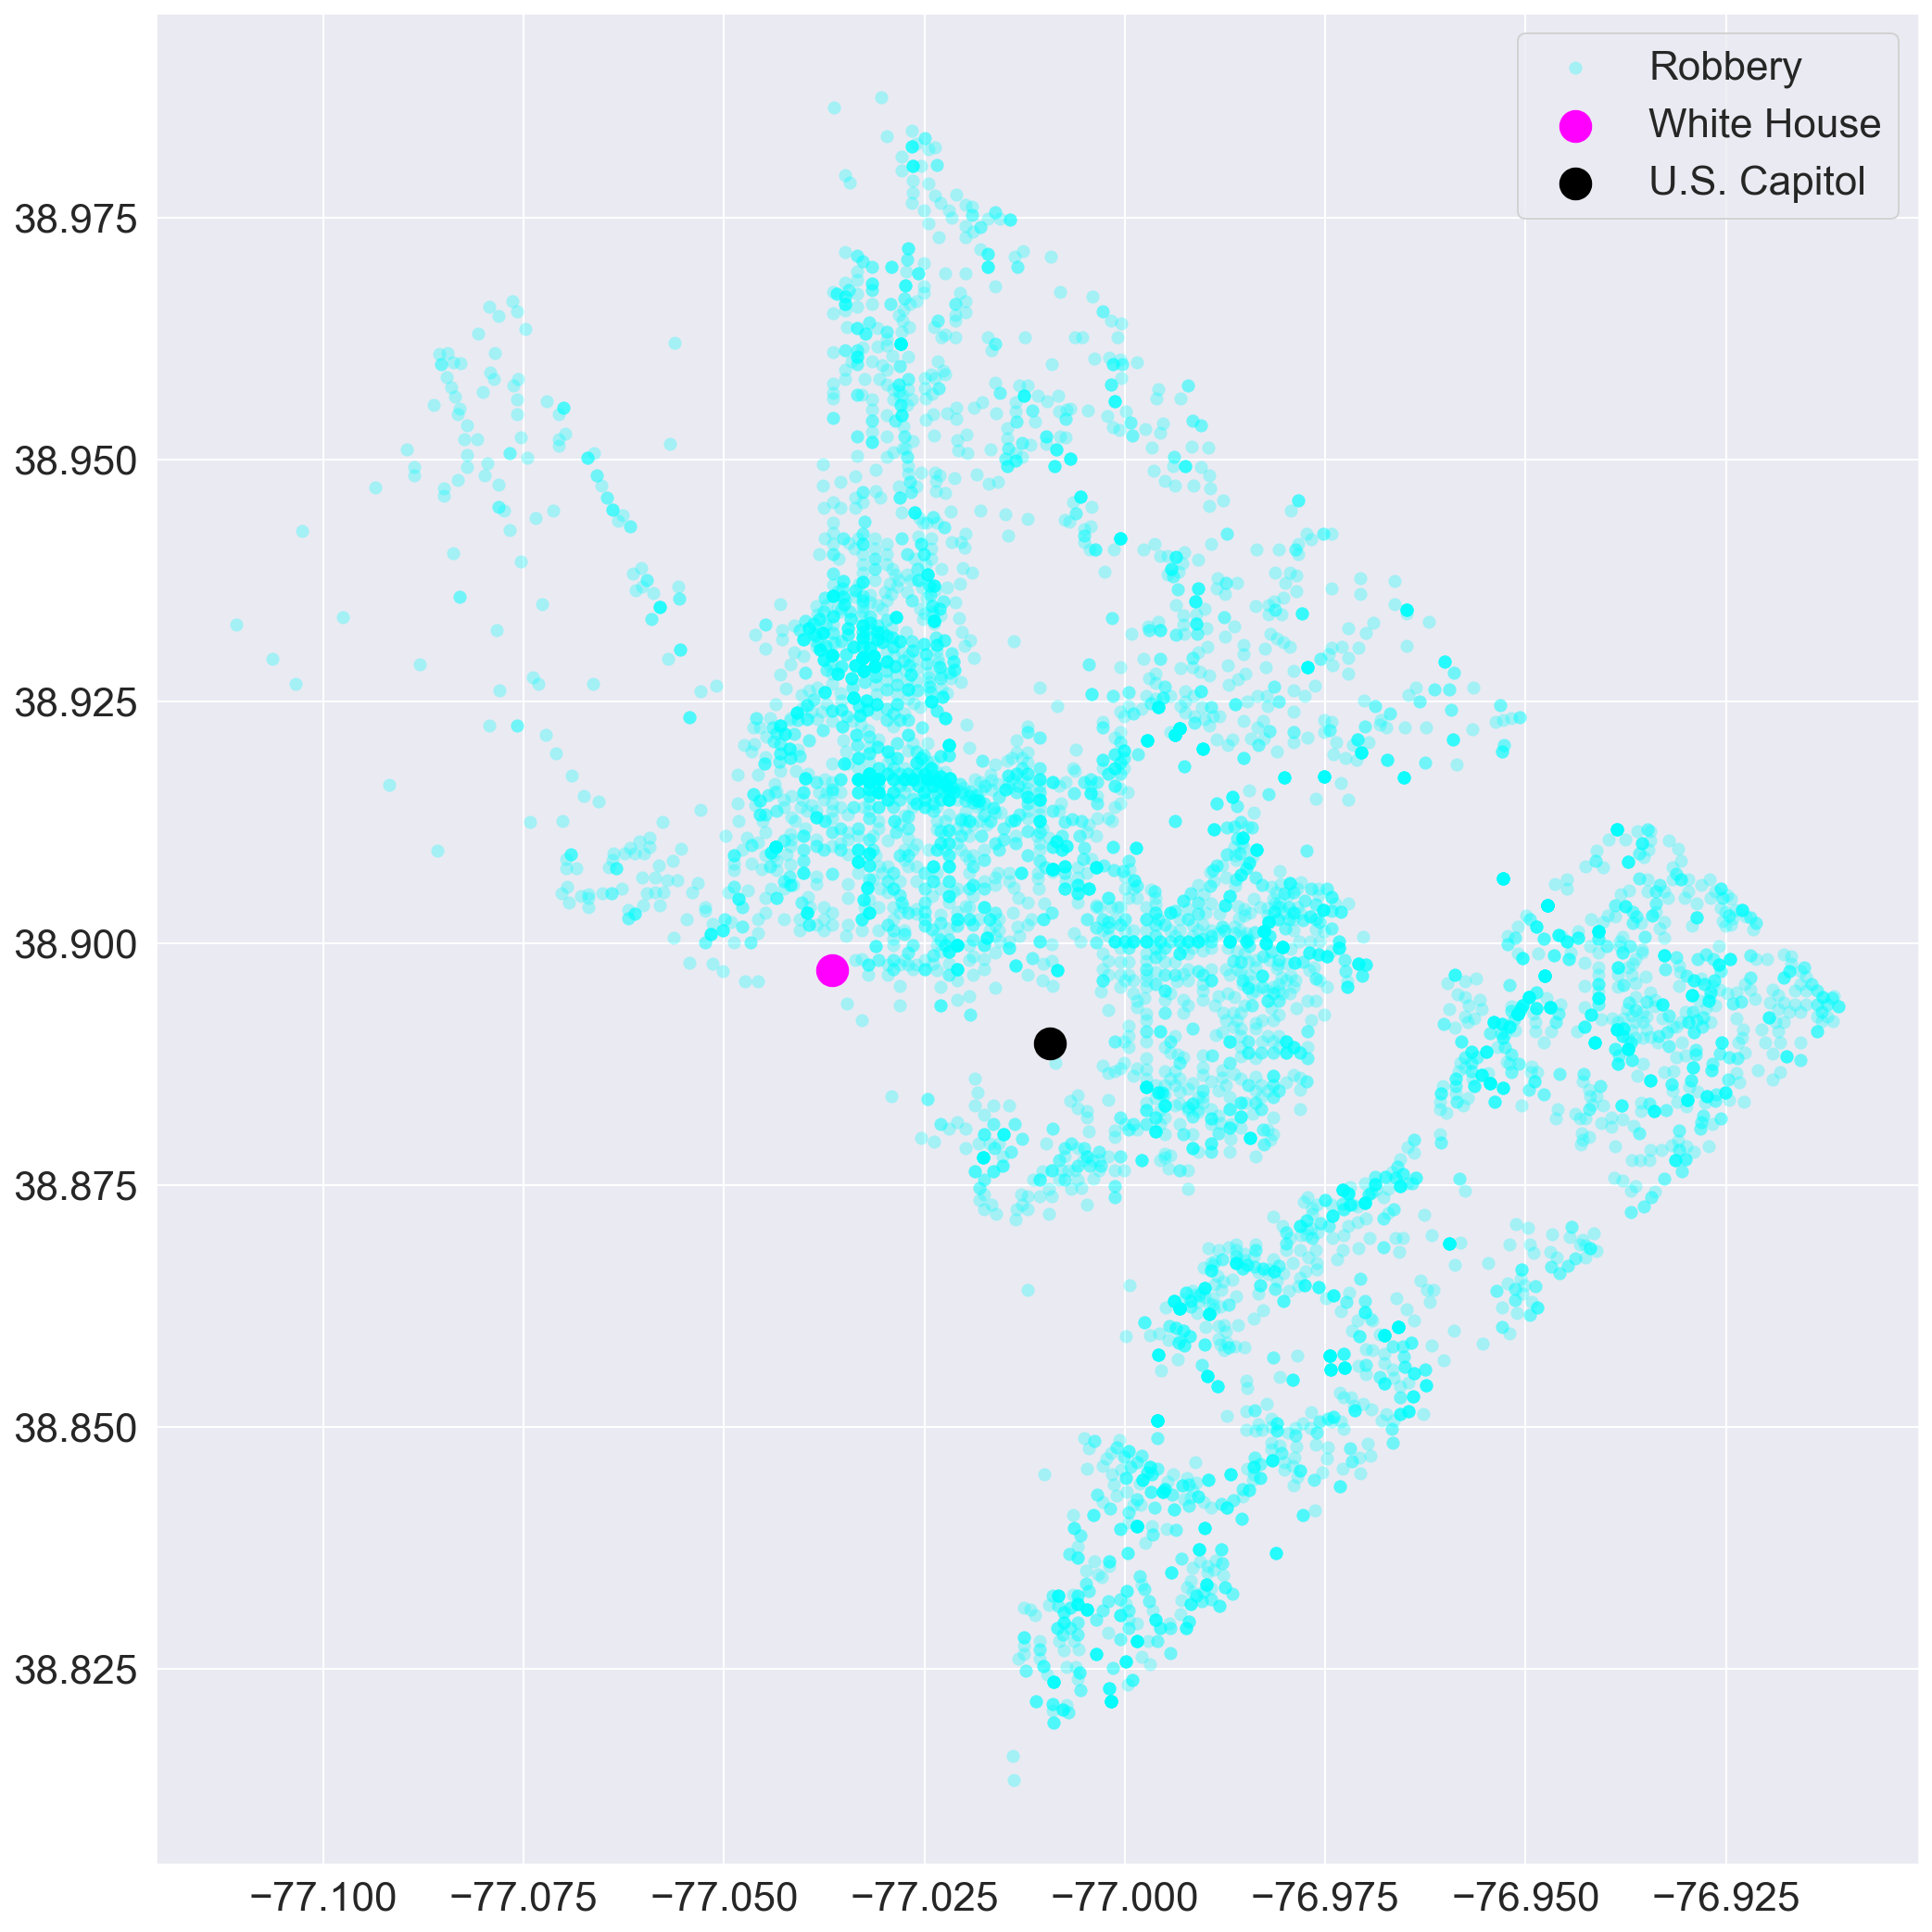

========================== violent crimes[ROBBERY] in Washington DC ===========================================


In [145]:
print("========================== Plot of violent[ROBBERY]crimes====================================================")
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ROBBERY'], data1['LATITUDE'][data1['OFFENSE']=='ROBBERY'], s=50, alpha=0.3, color=[0.0,1.0,1.0], lw=0, label='Robbery')
plt.scatter(-77.03654,38.89722,s=60, color=[1,0,1], lw=10, label='White House')
plt.scatter(-77.00937,38.88968,s=60, color=[0,0,0], lw=10, label='U.S. Capitol')
plt.legend(loc='upper right')
plt.show()
print("========================== violent crimes[ROBBERY] in Washington DC ===========================================")

========================== Plot of violent crimes=============================================================


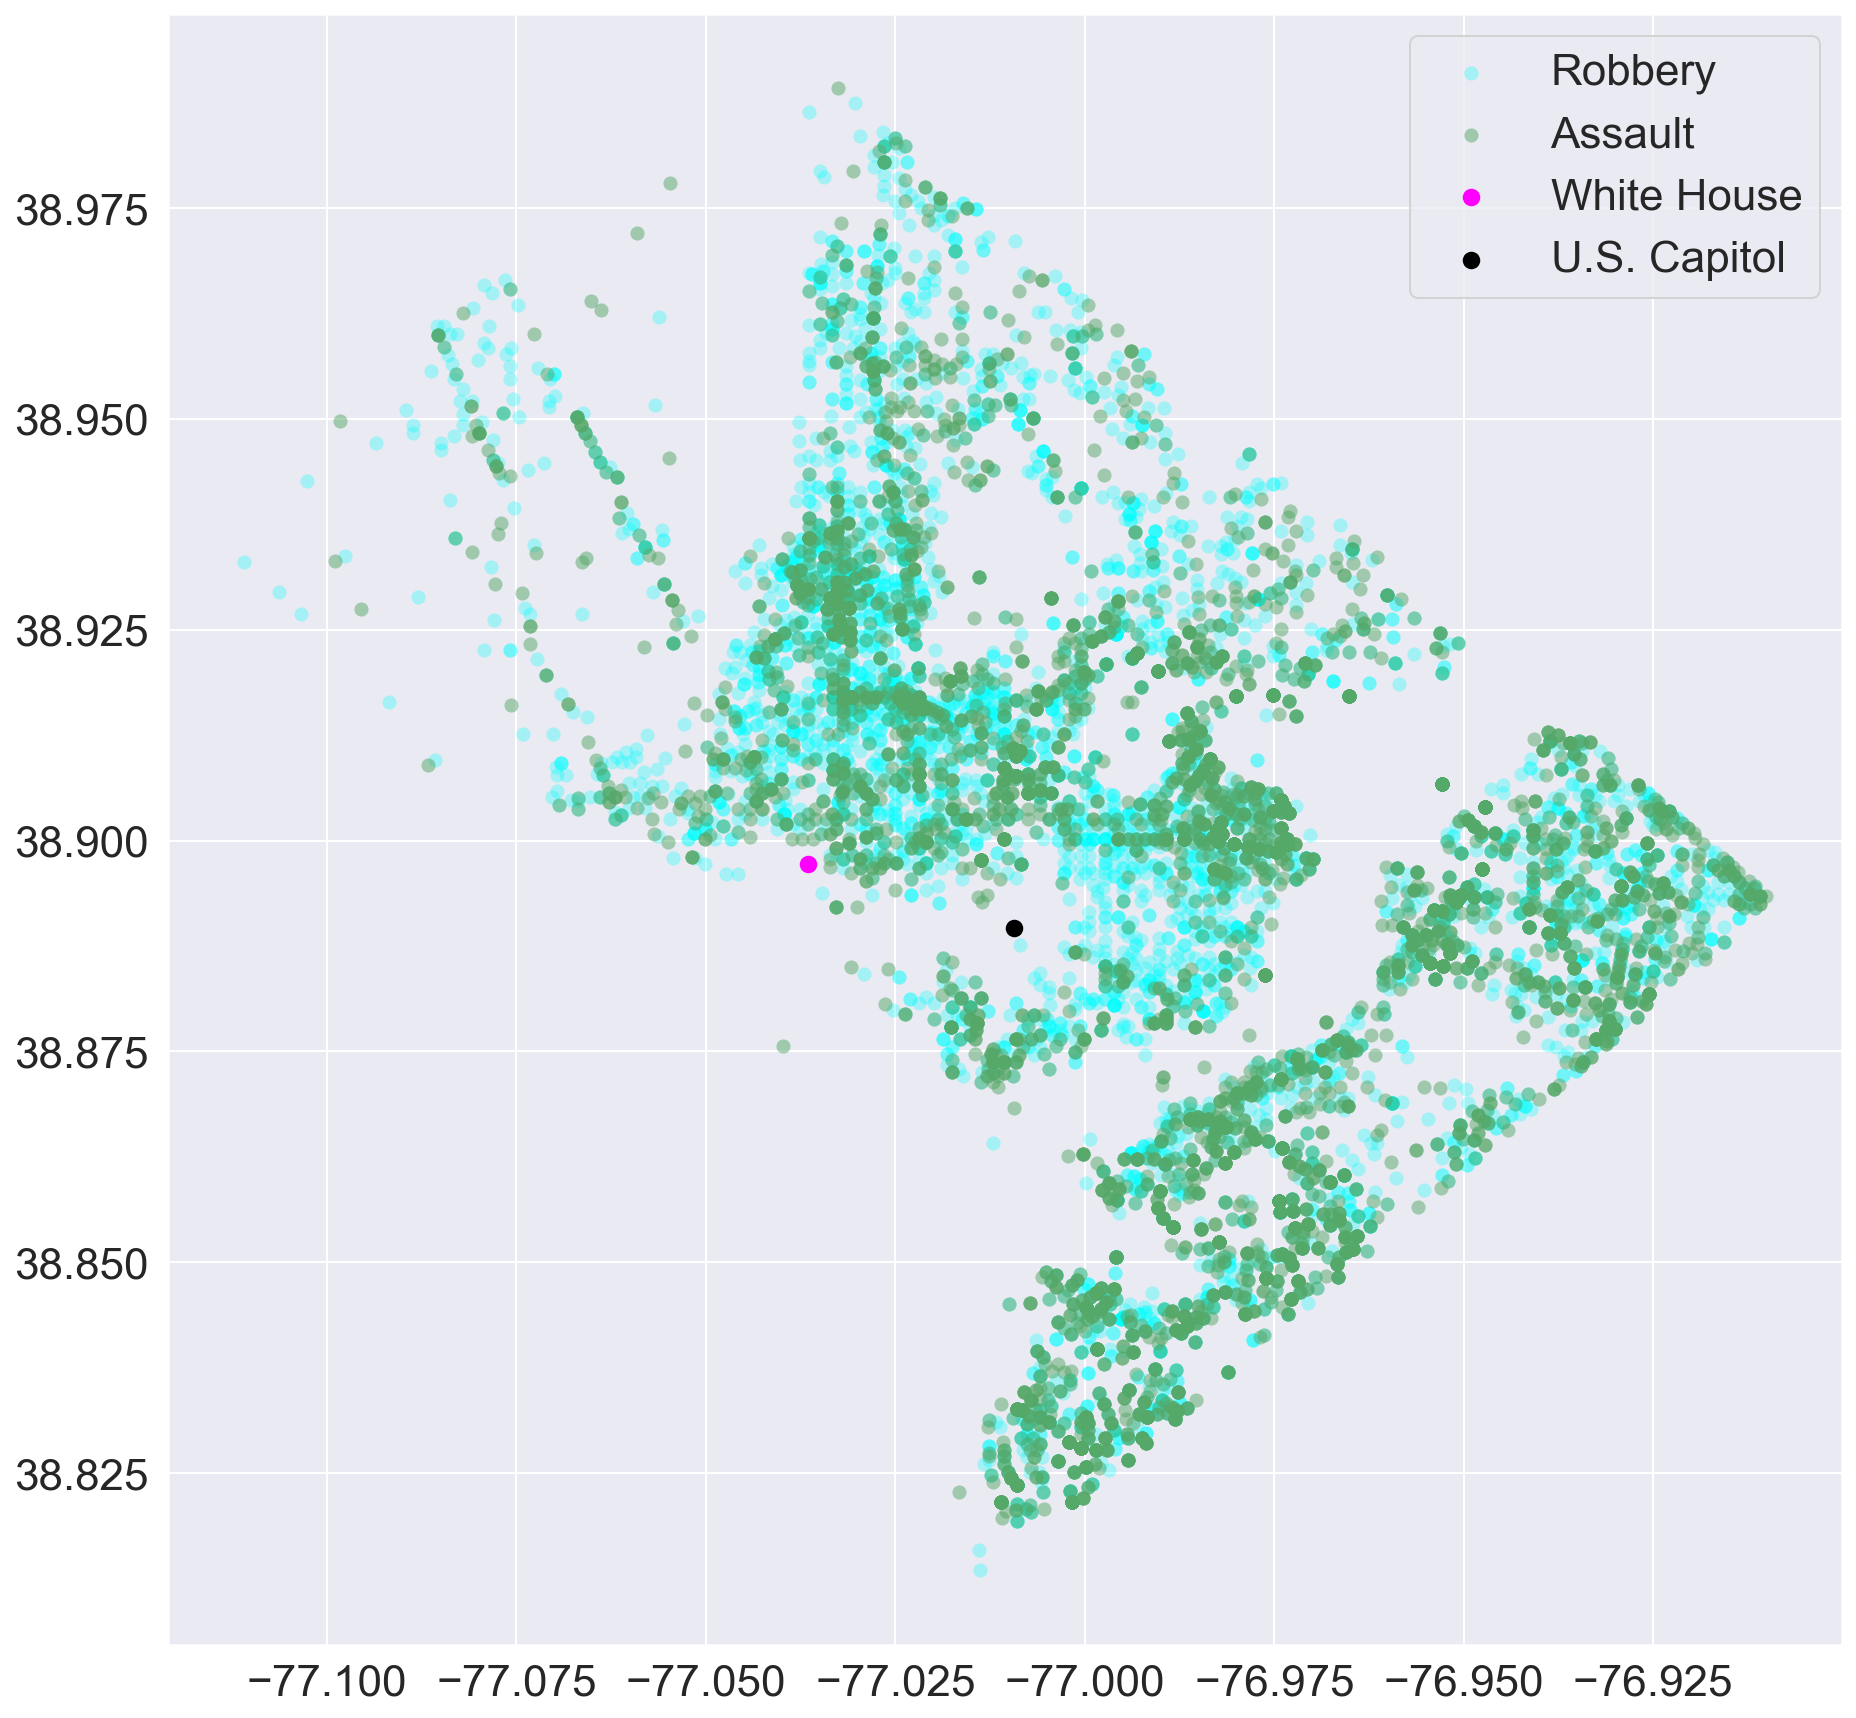

========================== violent crimes in Washington DC ====================================================


In [84]:
print("========================== Plot of violent crimes=============================================================")
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ROBBERY'], data1['LATITUDE'][data1['OFFENSE']=='ROBBERY'], s=50, alpha=0.3, color=[0.0,1.0,1.0], lw=0, label='Robbery')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], data1['LATITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], s=50, alpha=0.5, color='g', lw=0, label='Assault')
plt.scatter(-77.03654,38.89722,s=60, color=[1,0,1], lw=1, label='White House')
plt.scatter(-77.00937,38.88968,s=60, color=[0,0,0], lw=1, label='U.S. Capitol')
plt.legend(loc='upper right')
plt.show()
print("========================== violent crimes in Washington DC ====================================================")

========================== Plot of violent[ASSAULT W/DW] crimes======================================================


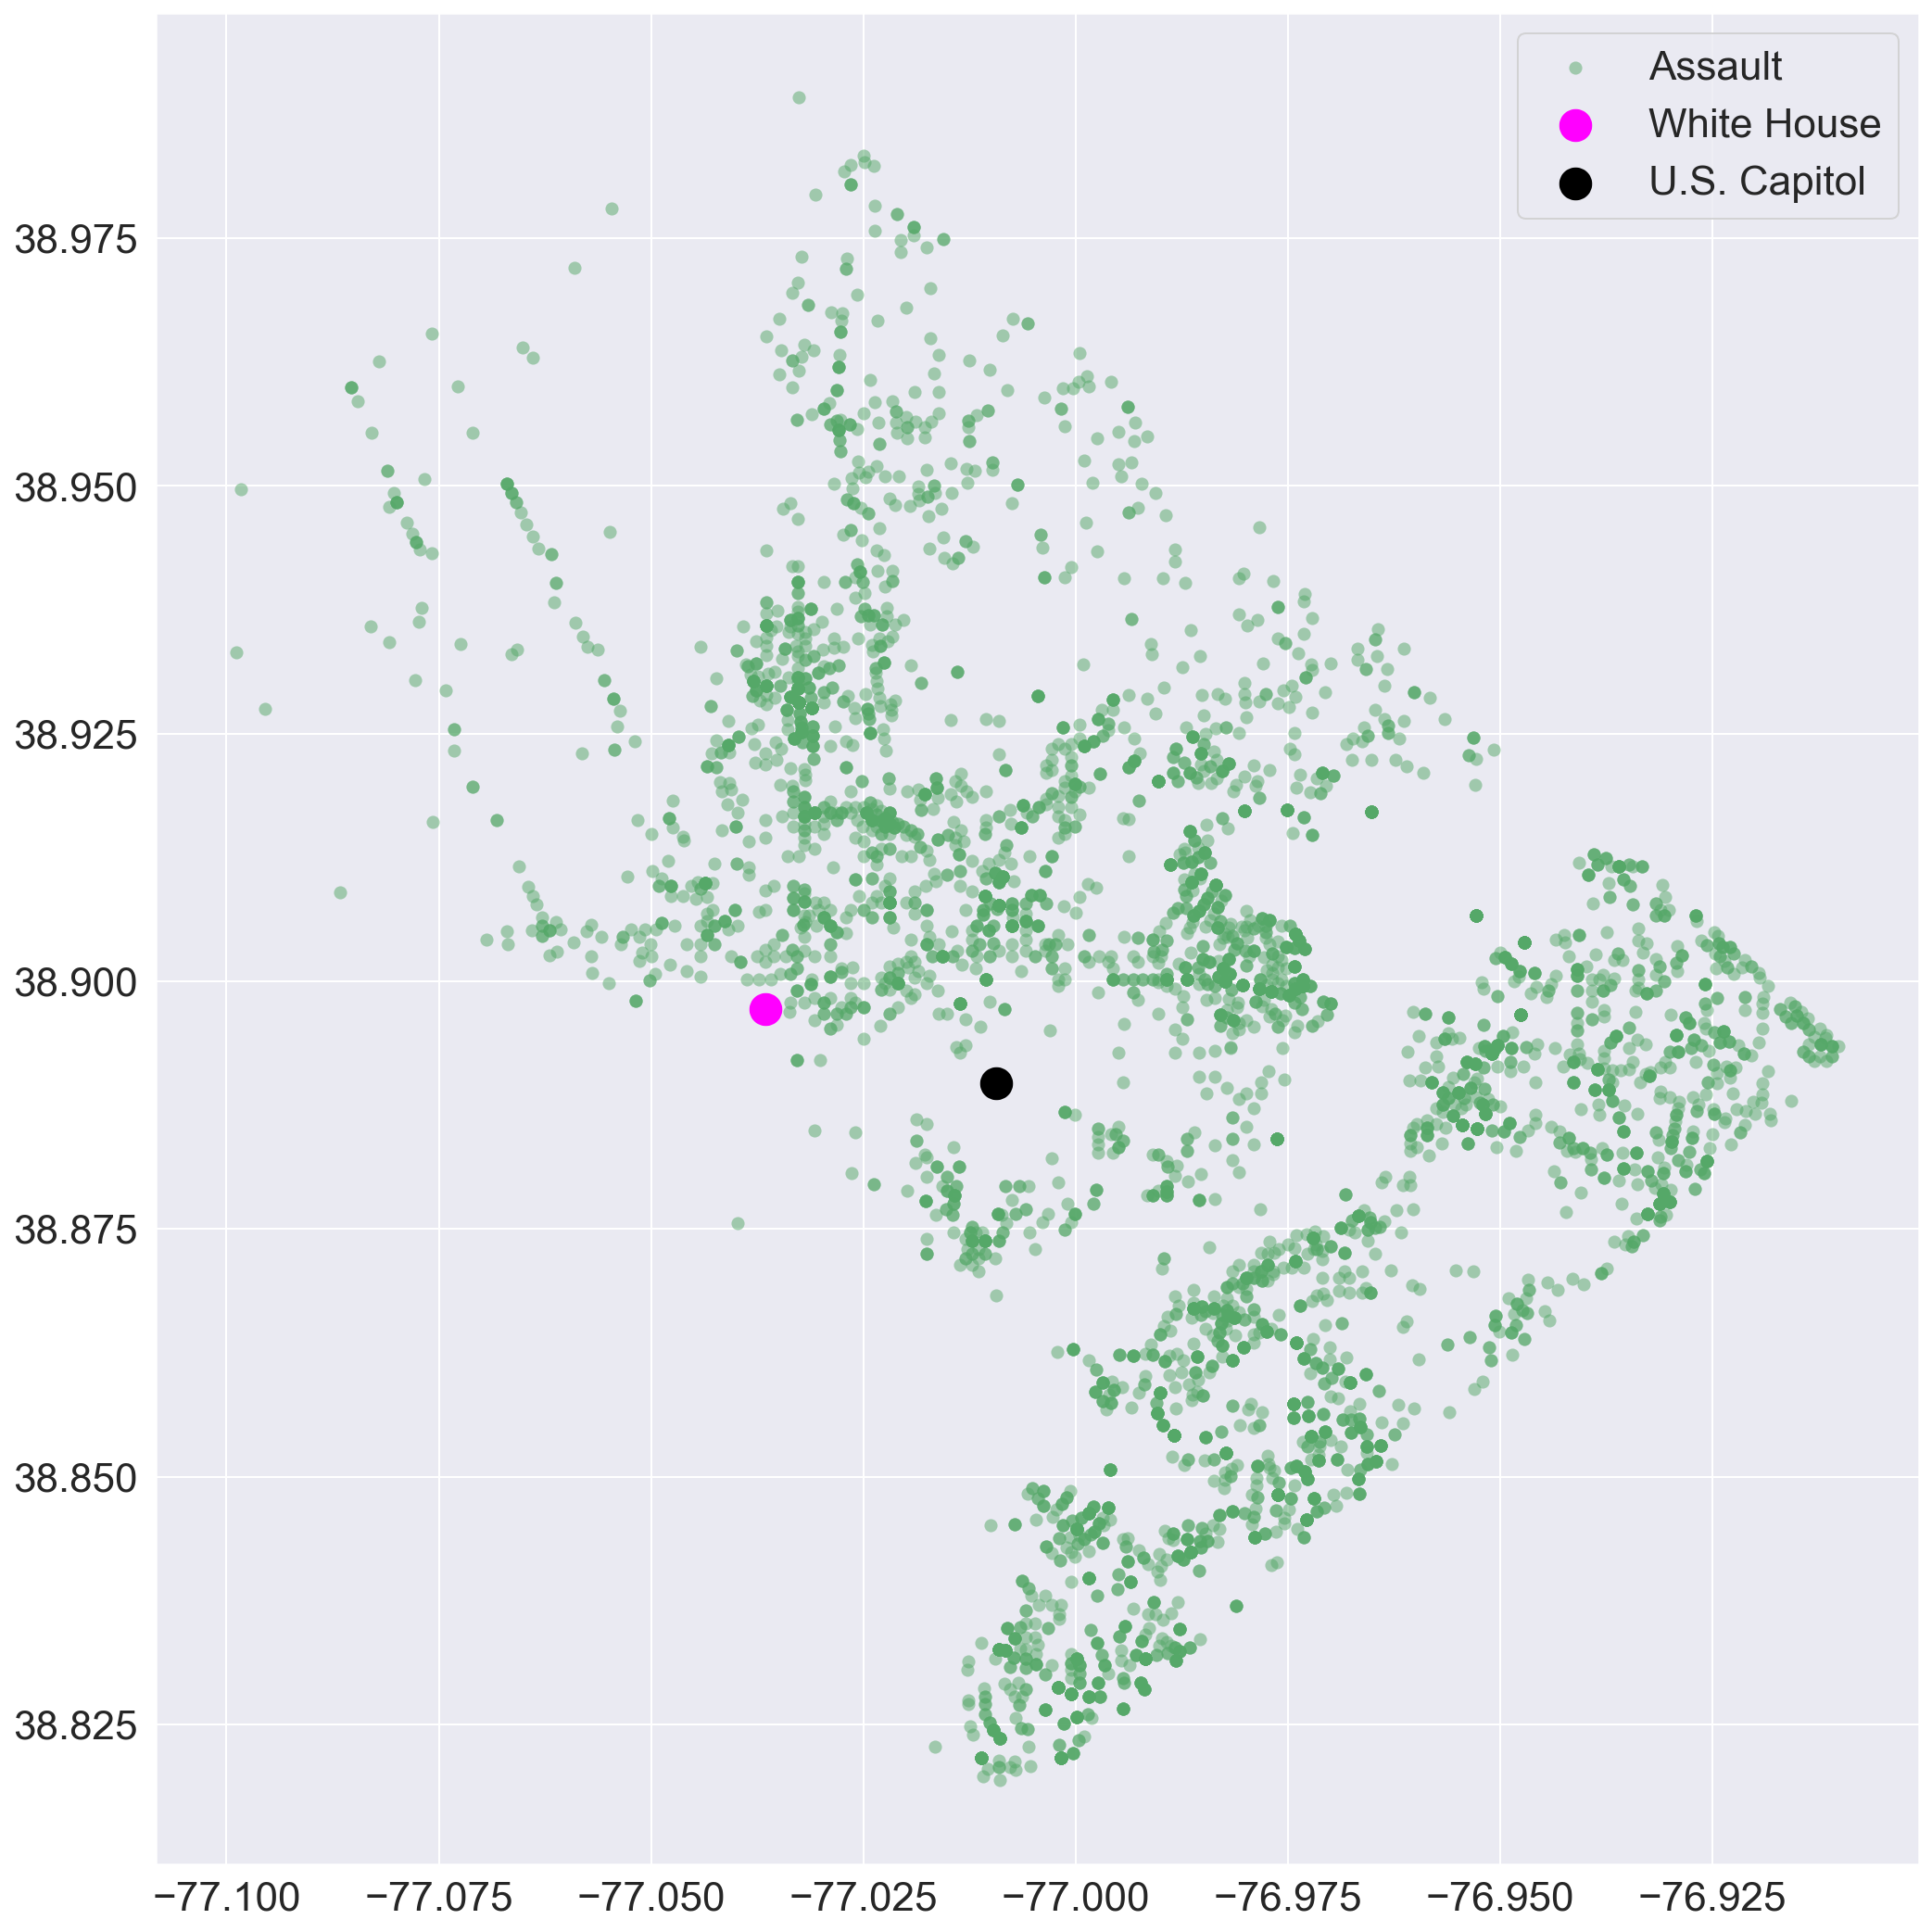

========================== violent crimes[ASSAULT W/DW] in Washington DC ===========================================


In [146]:

print("========================== Plot of violent[ASSAULT W/DW] crimes======================================================")
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)

plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], data1['LATITUDE'][data1['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'], s=50, alpha=0.5, color='g', lw=0, label='Assault')
plt.scatter(-77.03654,38.89722,s=60, color=[1,0,1], lw=10, label='White House')
plt.scatter(-77.00937,38.88968,s=60, color=[0,0,0], lw=10, label='U.S. Capitol')
plt.legend(loc='upper right')
plt.show()
print("========================== violent crimes[ASSAULT W/DW] in Washington DC ===========================================")

In [144]:
print("========================== Plot of violent[SEX ABUSE and HOMICIDE] crimes====================================")
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='SEX ABUSE'], data1['LATITUDE'][data1['OFFENSE']=='SEX ABUSE'], s=50, alpha=0.3, color='b', lw=0, label='Sex Abuse')
plt.scatter(data1['LONGITUDE'][data1['OFFENSE']=='HOMICIDE'], data1['LATITUDE'][data1['OFFENSE']=='HOMICIDE'], s=50, alpha=0.3, color='r', lw=0, label='Homicide')
plt.scatter(-77.03654,38.89722,s=60, color=[1,0,1], lw=10, label='White House')
plt.scatter(-77.00937,38.88968,s=60, color=[0,0,0], lw=10, label='U.S. Capitol')
plt.legend(loc='upper right')
plt.show()
print("========================== Plot of violent[SEX ABUSE and HOMICIDE] crimes ====================================")

========================== Plot of violent[SEX ABUSE and HOMICIDE] crimes====================================


========================== Plot of violent[SEX ABUSE and HOMICIDE] crimes ====================================


PLOT CORRELATION

In [90]:
def plot_corr(data1, size = 11):
    corr = data1.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax, shrink = .8)
    ax.grid(True)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 'vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

In [91]:
plot_corr(data1)
corrMatrix = data1.corr()
corrMatrix.to_csv('dc_crime1corr.csv')

# Defining features and modeling

In [117]:
# Using get_dummies on the SHIFT column so it can be used as a feature for modeling

dc3 = pd.get_dummies(data1, columns=['SHIFT'], drop_first=True)


In [118]:
dc3.columns

Index(['year', 'month', 'day', 'weekofyear', 'dayofweek', 'quarter', 'hour',
       'minute', 'second', 'CCN', 'METHOD', 'OFFENSE', 'BLOCK', 'WARD', 'ANC',
       'DISTRICT', 'PSA', 'NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'SHIFT_EVENING',
       'SHIFT_MIDNIGHT'],
      dtype='object')

In [132]:
# Defined features for modeling as X variable

features = ['LONGITUDE','LATITUDE','PSA','SHIFT_EVENING', 'SHIFT_MIDNIGHT','year','month','day','hour','dayofweek','WARD','weekofyear','quarter']

In [133]:
dc3.columns

Index(['year', 'month', 'day', 'weekofyear', 'dayofweek', 'quarter', 'hour',
       'minute', 'second', 'CCN', 'METHOD', 'OFFENSE', 'BLOCK', 'WARD', 'ANC',
       'DISTRICT', 'PSA', 'NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'SHIFT_EVENING',
       'SHIFT_MIDNIGHT'],
      dtype='object')

In [134]:
# Using fillna to get rid of null values in the dataframe

dc3.fillna(0,inplace=True)

In [135]:
# Defining X and y variables

X = dc3[features]
y = dc3['OFFENSE']

In [136]:
# Train, test split with a random state of 42

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [137]:
# Dropping null values

X_train.dropna(inplace=True)

C:\Users\dhinton\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
# Dropping null values

X_test.dropna(inplace=True)

C:\Users\dhinton\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
# Verifying no null values in data

X_train.isnull().sum().sum()

0

In [140]:
pipeline_optimizer = TPOTClassifier(generations=2, population_size=20,cv=5, verbosity=2,
                      config_dict='TPOT light')

In [141]:
pipeline_optimizer.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.46746524696835257

Generation 2 - Current best internal CV score: 0.46746524696835257

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=9, min_samples_leaf=10, min_samples_split=20)


TPOTClassifier(config_dict='TPOT light', generations=2, population_size=20,
               verbosity=2)